In [1]:
insert_animal = 'F'

In [2]:
inputEventTrace = '/Users/rufusmitchell-heggs/Desktop/data/preprocessing/AN'+insert_animal+'/preprocessed_files/AN'+insert_animal+'mega_events.csv'
inputTrace = '/Users/rufusmitchell-heggs/Desktop/data/preprocessing/AN'+insert_animal+'/preprocessed_files/AN'+insert_animal+'mega_trace.csv'

In [3]:
import random
import numpy as np
import statistics 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib as mpl
from matplotlib.pyplot import figure
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
from scipy import ndimage
from scipy import stats
from scipy.spatial import distance
from scipy.stats.stats import pearsonr 
import scipy.signal 
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

from sklearn import preprocessing
from itertools import cycle
import seaborn as sns
import math
from sklearn.model_selection import train_test_split

# import caiman as cm
# from caiman.source_extraction import cnmf

#plotting params
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['axes.edgecolor'] = 'black'
mpl.rcParams['axes.linewidth'] = '0.5'
mpl.rcParams['axes.labelsize'] = '8'
mpl.rcParams['axes.labelcolor'] = 'black'

mpl.rcParams['xtick.color'] = 'black'
mpl.rcParams['xtick.labelsize'] = '8'
mpl.rcParams['ytick.labelsize'] = '8'
mpl.rcParams['ytick.color'] = 'black'

In [4]:
data_event = pd.read_csv(inputEventTrace, sep=',', dtype=str, error_bad_lines=False, encoding="utf-8-sig")
data_trace = pd.read_csv(inputTrace, sep=',', dtype=str, error_bad_lines=False, encoding="utf-8-sig")
data_trace['unique_stage']=data_trace['stage']+data_trace['session'].astype(str)

In [5]:
def get_session(data_event_or_data_trace):
    """"get session takes the mega_event or trace file in and returns a list of all the session blocks
    INPUT:
    -------
    >> data_event_or_data_trace - mega_events OR mega_trace file
    
    OUTPUT:
    -------
    >> blocks - a list of all events or traces as in dataframe format """

    batches_dic = {'Exp1':1, 'Pre1':2, 'Nov1':3, 'Exp2':4, 'Pre2':5, 'Nov2':6, 'Exp3':7, 'Nov3':8}
    batches = list(set(data_event_or_data_trace.unique_stage))
    sorted_batches = []
    for i in batches:
        sorted_batches.append(batches_dic[i])
    sorted_batches.sort()

    batches = []
    for i in sorted_batches:
        batches.append(list(batches_dic.keys())[list(batches_dic.values()).index(i)])
    
    blocks = []
    for batch in batches:
        blocks.append(data_event_or_data_trace[data_event_or_data_trace['unique_stage']==batch])

    return blocks

events = get_session(data_event)
traces = get_session(data_trace

SyntaxError: unexpected EOF while parsing (<ipython-input-5-6f7f7e7ae918>, line 29)

In [ ]:
sesh = 1
stranger = 2
## --------------------------------------------------------------------------------------------------
traces_session = traces[sesh]
events_session = events[sesh]

animal_cell_count = {'F':238, 'I':126, 'L':74}
all_cells = traces_session.iloc[: , 2:animal_cell_count[insert_animal]] #<---- (ANF - 238 cells, ANI - 126 cells, ANL - 74 cells)
cells_dictionary = traces_session.iloc[: , 2:animal_cell_count[insert_animal]].loc[:,~(traces_session==" nan").any()].columns.values
nan_cells = (set(all_cells.columns.values).difference(cells_dictionary))

data_trace = np.array(traces_session[cells_dictionary].astype(float)).transpose()
data_trace = normalize(data_trace, axis = 1)
data_events =np.array(events_session[cells_dictionary].astype(float)).transpose()
data_events_normalized = normalize(data_events, axis=1)

behav_vector = np.array(traces_session['raw_behaviour'].astype(float))

cage = stranger
behav_vec_cropped = []
for i in behav_vector:
    if cage == 2:
        if i == 2:
            behav_vec_cropped.append(1)
        elif i == 1:
            behav_vec_cropped.append(0)
        else:
            behav_vec_cropped.append(0) 
    elif cage == 1:
        if i == 2:
            behav_vec_cropped.append(0)
        elif i == 1:
            behav_vec_cropped.append(1)
        else:
            behav_vec_cropped.append(0) 
    elif cage == 'both':
        if i > 0:
            behav_vec_cropped.append(1)
        else:
            behav_vec_cropped.append(0) 
    
behav_vector = np.array(behav_vec_cropped)

plt.plot(behav_vector)

In [ ]:
def spike_binning(spike_array, bin_size=4):
    bin_size = bin_size
    binned_spikes = []
    for neuron in spike_array:
        per_neuron=[]
        i=0
        while i <= len(neuron):
            per_neuron.append(sum(neuron[i:i+bin_size]))
            i+=bin_size
        binned_spikes.append(per_neuron)
    return binned_spikes

def trace_binning(spike_array, bin_size=4):
    bin_size = bin_size
    binned_spikes = []
    for neuron in spike_array:
        per_neuron=[]
        i=0
        while i <= len(neuron):
            per_neuron.append(np.mean(neuron[i:i+bin_size]))
            i+=bin_size
        binned_spikes.append(per_neuron)
    return binned_spikes

def behav_vector_binning(behav_vector, bin_size=4):
    bin_size = bin_size
    binned_behav_vector = []
    i=0
    while i <= len(behav_vector):
        binned_behav_vector.append(stats.mode(behav_vector[i:i+bin_size])[0])
        i+=bin_size
    return binned_behav_vector

binned_data_trace = np.array(trace_binning(data_trace))
binned_data_events = np.array(spike_binning(data_events_normalized))
binned_behav_vector = np.array(behav_vector_binning(behav_vector)).transpose()[0]

num_frames = num_frames = len(binned_behav_vector)

In [ ]:
#Define all functions
def similarity_calc(calcium_trace_vectors, behav_vector):
    """ 
    Calculate the similarity score between calcium trace vectors and behvioral vector 
    
    INPUT:
    -------
    >> calcium_trace_vectors - all calcium traces as np.array
    >> behav_vector - behavioral vector
    
    OUTPUT:
    -------
    >> similarity - the similarity score
    """
    similarity = []
    for i in range(len(calcium_trace_vectors)):
        similarity.append(np.dot((2*behav_vector),calcium_trace_vectors[i])/((np.linalg.norm(behav_vector)**2)+(np.linalg.norm(calcium_trace_vectors[i])**2)))
    return similarity


def behav_vectors(behavioral_vector):
    """ 
    Create a new matrix that replaces sequences of ones 
    with the length of the sequence of ones
    
    INPUT:
    -------
    >> behavioral_vector - the original behavioral vector
    
    OUTPUT:
    -------
    >> behav_vectors - adpated behavioral vector (e.g. 001100111 --> 002003)
    """
    behav_vectors = []
    for i in range(len(behavioral_vector)):
        if i > 0:
            if behavioral_vector[i] > 0 and behavioral_vector[i-1] == 0:
                count = 0
                idx = 0
                while behavioral_vector[i+idx] != 0 in behavioral_vector[i:]:
                    idx +=1
                    count +=1
                behav_vectors.append(count)
            elif behavioral_vector[i] !=1 :
                behav_vectors.append(behavioral_vector[i])
        elif behavioral_vector[i] != 1:
            behav_vectors.append(behavioral_vector[i])
        
    return behav_vectors

def shuffled_vector_scores(behavioral_vector, calcium_traces, shuffles = 5000):
    """ 
    Creates n shuffles of the behavioral vector and calculates the new similarity 
    score between behavioral vectors and calcium trace vectors
    INPUT:
    -------
    >> behavioral_vector -  use behav_vectors func
    >> calcium_traces - (raw calcium trace for each file)
    >> shuffles - the number of times to shuffle the data (default = 5000)
    
    OUTPUT:
    -------
    >> similarity_shuffled_all - Similarity score for calcium trace vectors and shuffled behavioral vector
    >> similarity_calcium_traces - Shuffled behavioral vectors (as a list)
    """
    similarity_shuffled_all = []
    new_seq_all = []
    for i in range(shuffles):
        np.random.shuffle(behavioral_vector)
        
        indexes = []
        num_ones = []
        behav_vector_all = np.zeros(num_frames)
        for vector in range(len(behavioral_vector)):
            if behavioral_vector[vector] > 0:
                indexes.append(np.arange(vector, vector+behavioral_vector[vector],1))
                num_ones.append(np.ones(behavioral_vector[vector]))            
        indexes = np.array(np.concatenate(indexes).ravel().tolist())
        num_ones = np.array(np.concatenate(num_ones).ravel().tolist())
        behav_vector_all[indexes] = num_ones
        new_seq_all.append(behav_vector_all)
        similarity_shuffled_all.append(similarity_calc(calcium_traces, behav_vector_all))  
    
    return similarity_shuffled_all, new_seq_all

def percentile(similarity_shuffled_all, similarity_calcium_traces):
    """ 
    Calculates the percentile of the calcium trace vector similarity score
    INPUT:
    -------
    >> similarity_shuffled_all -  use shuffled_vector_scores function
    >> similarity_calcium_traces - use similarity_calc
    
    OUTPUT:
    -------
    >> percentile - percentile out of shuffled dsimilarity score distribution
    >> similarity_distribution_all - similarity score distribution for all behav_vectors
    """
    similarity_distribution_all = []
    percentile = []
    for i in range(len(similarity_shuffled_all[0])):
        similarity_distribution = []
        for j in range(len(similarity_shuffled_all)):
            similarity_distribution.append(similarity_shuffled_all[j][i])
        percentile.append(stats.percentileofscore(similarity_distribution, similarity_calcium_traces[i]))
        similarity_distribution_all.append(similarity_distribution)
    return [percentile, similarity_distribution_all]    

In [ ]:
#perc = percentile, dist = distribution of scores for n shuffled behavioral vectors
similarity = similarity_calc(binned_data_trace, binned_behav_vector)
perc, dist = percentile(shuffled_vector_scores(behav_vectors(binned_behav_vector), binned_data_trace, shuffles=10000)[0], similarity)

In [ ]:
on = []
on_index = []
off = []
off_index = []
for i in range(len(perc)):
    if perc[i] >= 99.17:
        on.append(i)
        on_index.append(i)
    elif perc[i] <= 0.83:
        off.append(i)
        
sigma = 10

normalised_neurons_on = []
normalised_neurons_off = []

smoothed_normalised_neurons_on = []
smoothed_normalised_neurons_off = []
for i in on:
    normalise = normalize(binned_data_trace[i][:,np.newaxis], axis=0)
    normalised_neurons_on.append(normalise)
    smoothed_normalised_neurons_on.append(ndimage.gaussian_filter1d(np.random.rand(num_frames)*normalise.transpose()[0], 100))

for i in off:    
    normalise = normalize(binned_data_trace[i][:,np.newaxis], axis=0)
    normalised_neurons_off.append(normalise)
    smoothed_normalised_neurons_off.append(ndimage.gaussian_filter1d(np.random.rand(num_frames)*normalise.transpose()[0], 100))

    
normalised_neurons_on_mean = np.mean(normalised_neurons_on, axis=0).transpose()

normalised_neurons_on_sem =  stats.sem(normalised_neurons_on).transpose()
normalised_neurons_off_mean = np.mean(normalised_neurons_off, axis=0).transpose()
normalised_neurons_off_sem =  stats.sem(normalised_neurons_off).transpose()*1.96
                                                             
smoothed_on = ndimage.gaussian_filter1d(np.random.rand(num_frames)*normalised_neurons_on_mean, sigma)
smoothed_off = ndimage.gaussian_filter1d(np.random.rand(num_frames)*normalised_neurons_off_mean, sigma)
smoothed_on_cell = ndimage.gaussian_filter1d(np.random.rand(num_frames)*normalised_neurons_on[0].transpose()[0], sigma) 
frame = np.arange(0,len(normalised_neurons_on_mean[0]),1)
time = np.arange(0, (len(frame)-0.05006)*0.05006, 0.05006)
smoothed_normalised_neurons_on_sem = ndimage.gaussian_filter1d(np.random.rand(num_frames)*normalised_neurons_on_sem, sigma)
smoothed_normalised_neurons_off_sem = ndimage.gaussian_filter1d(np.random.rand(num_frames)*normalised_neurons_off_sem, sigma)

on_heat = np.array(smoothed_normalised_neurons_on)
off_heat = np.array(smoothed_normalised_neurons_off)



In [ ]:
def consistency(data_events, behavioural_vector, status='on'):
    interaction_bouts = []
    bout = []        
    for i in range(len(behavioural_vector)):     
        if behavioural_vector[i] == 1:
            bout.append(i)
        elif len(bout) > 0:
            interaction_bouts.append([min(bout), max(bout)])
            bout = []
        else:
            bout = []

    engagement_matrix_all = []
    consistency_all = []
    for neuron in data_events:
        engagement_matrix = []
        for i in interaction_bouts:
            if status == 'on':
                if sum(neuron[i[0]:i[1]]) > 0:
                    engagement_matrix.append(1)
                else:
                    engagement_matrix.append(0)
            elif status =='off':
                if sum(neuron[i[0]:i[1]]) == 0:
                    engagement_matrix.append(1)
                else:
                    engagement_matrix.append(0)
                    
        engagement_matrix_all.append(engagement_matrix)
        consistency_all.append((sum(engagement_matrix)/len(interaction_bouts))*100)
    engagement_matrix_all = np.array(engagement_matrix_all)
    consistency_all = np.array(consistency_all)
    
    return engagement_matrix_all, consistency_all

on_engagement, on_consistency_all = consistency(binned_data_events[on], binned_behav_vector, status = 'on')
off_engagement, off_consistency_all = consistency(binned_data_events[off], binned_behav_vector, status='off')

plt.figure(figsize=(2, 2), dpi=200)
im = plt.pcolor(on_engagement, cmap='Greens', alpha=0.6, edgecolors='black', linewidth=1)
plt.savefig('/Users/rufusmitchell-heggs/Desktop/Thesis/all_figures/represent_engagematrix_on.png', format='png', dpi=600, bbox_inches = 'tight')
plt.show()

plt.figure(figsize=(2, 2), dpi=200)
plt.pcolor(off_engagement,cmap='Purples', alpha = 0.6, edgecolors='black', linewidth=1)
plt.savefig('/Users/rufusmitchell-heggs/Desktop/Thesis/all_figures/represent_engagematrix_off.png', format='png', dpi=600, bbox_inches = 'tight')
plt.show()

plt.plot(binned_data_events[on[0]])

plt.plot(binned_data_trace[on[0]])
plt.plot(binned_behav_vector)

In [ ]:
on_cells = list(cells_dictionary[on])
off_cells = list(cells_dictionary[off])

if len(on_cells) < 30:
    while len(on_cells) < 30:
        on_cells.append(0)
if len(off_cells) < 30:
    while len(off_cells) < 30:
        off_cells.append(0)

csvfile = pd.read_csv(inputTrace[:-17]+'onoff_liang.csv')
csvfile[traces_session['unique_stage'].iloc[1]+'on']= on_cells
csvfile[traces_session['unique_stage'].iloc[1]+'off']= off_cells
csvfile.to_csv(inputTrace[:-17]+'onoff_liang.csv')

In [ ]:

fig, axs = plt.subplots(3, 1, figsize=(10,3), dpi=200, facecolor='w', edgecolor='k')
gs = gridspec.GridSpec(3, 1, height_ratios=[1.5, 2,2]) 

axs[0] = plt.subplot(gs[0], )
axs[0].plot(time, binned_behav_vector, color = 'royalblue')
axs[0].tick_params(axis=u'both', which=u'both',length=0)
axs[0].set_xlim(0, max(time))
plt.setp(axs[0].get_xticklabels(), visible=False)
# plt.ylabel("Behavioral" + "\n" + "vector")


binned_behav_vector1 = [x * max(binned_data_trace[65]) for x in binned_behav_vector]

axs[1] = plt.subplot(gs[1])
axs[1].plot(time, normalised_neurons_on[0], color = 'blue')
axs[1].plot(time, binned_behav_vector1,linewidth=0.02, color = 'black')
axs[1].fill_between(time, 0, binned_behav_vector1, color='black', alpha = 0.05 )
axs[1].tick_params(axis=u'both', which=u'both',length=0)
axs[1].patch.set_facecolor('blue')
axs[1].patch.set_alpha(0.05)
axs[1].set_xlim(0, max(time))

axs[1].tick_params(bottom=False, left=False, right=False, labelleft=True, labelbottom=False)

axs[2] = plt.subplot(gs[2])
axs[2].plot(time, normalised_neurons_off[0], color = 'red')
axs[2].patch.set_facecolor('red')
axs[2].patch.set_alpha(0.05)
axs[2].set_xlim(0, max(time))
axs[2].tick_params(bottom=True, left=False, right=False, labelleft=True, labelbottom=True)


fig.text(0.035, 0.8,"Behavioural" + "\n" + " Vector", ha='center', va='center', rotation='vertical')

fig.text(0.03, 0.4,r"Normalised $\Delta F / F $", ha='center', va='center', rotation='vertical')
fig.text(0.06, 0.55,"ON cells", ha='center', va='center', rotation='vertical')
fig.text(0.06, 0.25,"OFF cells", ha='center', va='center', rotation='vertical')

plt.subplots_adjust(wspace=0, hspace=0)
plt.xlabel("Time (s)")
plt.show()

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(10,5), dpi=200, facecolor='w', edgecolor='k')
gs = gridspec.GridSpec(5, 1, height_ratios=[1.5,2,2,2,2]) 

axs[0] = plt.subplot(gs[0])
axs[0].plot(time, behav_vec_cropped, color = 'royalblue')
axs[0].tick_params(axis=u'both', which=u'both',length=0)
axs[0].set_xlim(0, max(time))
# axs[0].set_xlim(0, len(behav_vec_cropped))
plt.setp(axs[0].get_xticklabels(), visible=False)
# plt.ylabel("Behavioral" + "\n" + "vector", labelpad=50)


axs[1]=plt.subplot(gs[1])
axs[1].imshow(on_heat, cmap="coolwarm", aspect='auto', extent=[0,600,0,600])
axs[1].tick_params(bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
# axs[3].ylabel("ON cells")
axs[1].set_xlim(0, max(time))
axs[1]=plt.tick_params(bottom=False, left=False, right=False, labelleft=False
                       , labelbottom=False)

axs[2] = plt.subplot(gs[2])
axs[2].plot(time, smoothed_on[0], color = 'blue')
axs[2].fill_between(time, smoothed_on[0]-smoothed_normalised_neurons_on_sem[0], smoothed_on[0]+smoothed_normalised_neurons_on_sem[0], facecolor='skyblue')
axs[2].patch.set_facecolor('blue')
axs[2].patch.set_alpha(0.05)
axs[2].set_ylim(-0.01, 0.03)
axs[2].set_xlim(0, max(time))
# axs[1].errorbar(frame, normalised_neurons_on_mean[0], yerr=normalised_neurons_on_sem[0], capsize=0, ecolor='k',  marker='o',markersize=2, color='k')
axs[2]=plt.tick_params(bottom=False, left=True, right=False, labelleft=True, labelbottom=False)
# plt.ylabel('ON cells')

# plt.ylabel('OFF cells')
# axs[2].plot(smoothed_off[0], color = 'r')
# axs[2].fill_between(frame, smoothed_on[0]-smoothed_normalised_neurons_on_sem[0], smoothed_on[0]+smoothed_normalised_neurons_on_sem[0], facecolor='blue')
# axs[2].set_xlim(0, len(behav_vec_cropped))
# axs[1].errorbar(frame, normalised_neurons_on_mean[0], yerr=normalised_neurons_on_sem[0], capsize=0, ecolor='k',  marker='o',markersize=2, color='k')
# axs[2].fill_between(frame, smoothed_off[0]-smoothed_normalised_neurons_off_sem[0], smoothed_off[0]+smoothed_normalised_neurons_off_sem[0], facecolor='skyblue')

on_heat = np.array(smoothed_normalised_neurons_on)
off_heat = np.array(smoothed_normalised_neurons_off)

axs[3]=plt.subplot(gs[3])
axs[3].imshow(off_heat, cmap="coolwarm", aspect='auto',  extent=[0,600,0,600])
# axs[4]=plt.colorbar(orientation="horizontal", pad=0.2, shrink=0.4, ax=axs[4])
axs[3].tick_params(bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
# axs[4].ylabel("OFF cells")
axs[3].set_xlim(0, max(time))

axs[4] = plt.subplot(gs[4])
axs[4].plot(time, smoothed_off[0], color = 'blue')
axs[4].fill_between(time, smoothed_off[0]-smoothed_normalised_neurons_off_sem[0], smoothed_off[0]+smoothed_normalised_neurons_off_sem[0], facecolor='skyblue')
axs[4].patch.set_facecolor('blue')
axs[4].patch.set_alpha(0.05)
axs[4].set_ylim(-0.01, 0.03)
axs[4].set_xlim(0, max(time))
axs[4]=plt.tick_params(bottom=True, left=False, right=False, labelleft=True, labelbottom=True)

fig.text(0.03, 0.8,"Behavioural" + "\n" + " Vector", ha='center', va='center', rotation='vertical')
fig.text(0.03, 0.45,r"Normalised $\Delta F / F $", ha='center', va='center', rotation='vertical')
fig.text(0.06, 0.6,"ON cells", ha='center', va='center', rotation='vertical')
fig.text(0.06, 0.3,"OFF cells", ha='center', va='center', rotation='vertical')

plt.subplots_adjust(wspace=0, hspace=0)
plt.xlabel("Time (s)")
plt

plt.show()


In [ ]:

fig, axs = plt.subplots(3, 1, figsize=(10,4), dpi=200, facecolor='w', edgecolor='k')
gs = gridspec.GridSpec(3, 1, height_ratios=[1,2,3]) 

axs[0] = plt.subplot(gs[0])
axs[0].plot(behav_vec_cropped, color = 'blue')
axs[0].tick_params(axis=u'both', which=u'both',length=0)
axs[0].set_xlim(0, len(behav_vec_cropped))
axs[0]=plt.ylabel("Behavioral" + "\n" + "vector")
axs[0]=plt.tick_params(bottom=True, left=True, right=False, labelleft=True, labelbottom=False)

axs[1]=plt.subplot(gs[1])
axs[1]=plt.imshow(on_heat, cmap="coolwarm", aspect='auto', extent=[0,600,0,600])
axs[1]=plt.tick_params(bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
axs[1]=plt.ylabel("ON cells")

axs[2]=plt.subplot(gs[2])
axs[2]=plt.imshow(off_heat, cmap="coolwarm", aspect='auto',  extent=[0,600,0,600])
axs[2]=plt.colorbar(orientation="horizontal", pad=0.2, shrink=0.4)
axs[2]=plt.tick_params(bottom=True, left=False, right=False, labelleft=False, labelbottom=True)
axs[2]=plt.ylabel("OFF cells")

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

0


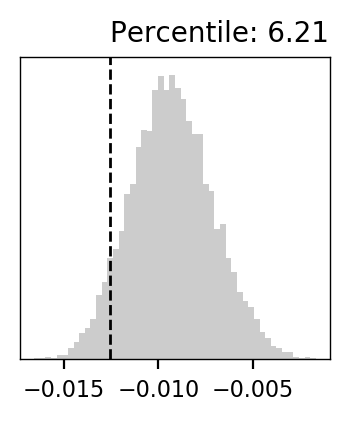

1


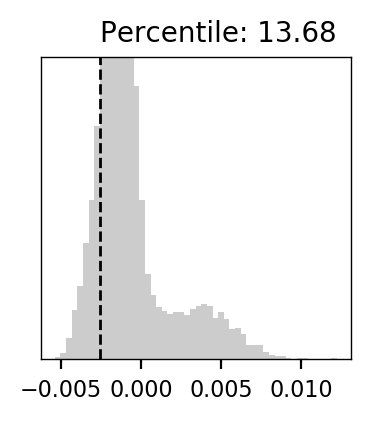

2


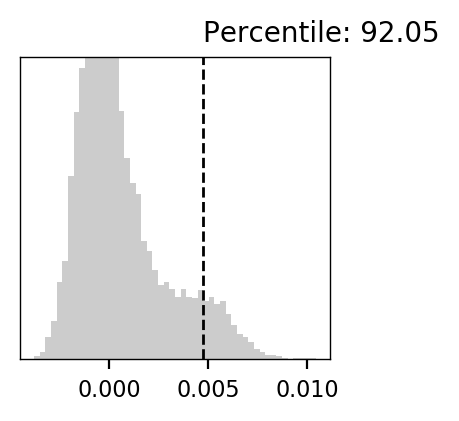

4


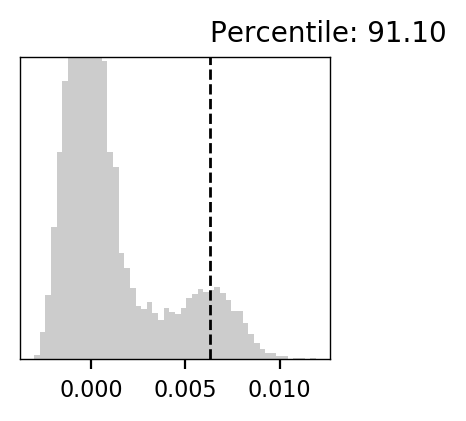

5


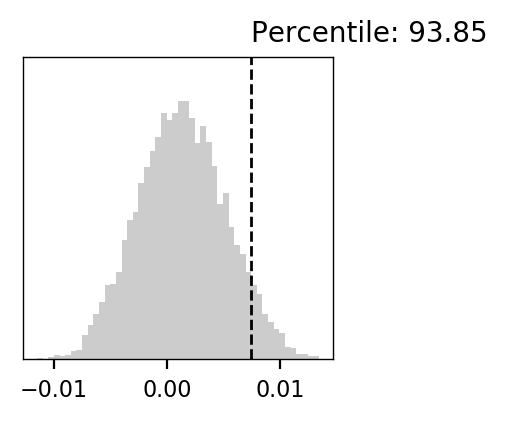

6


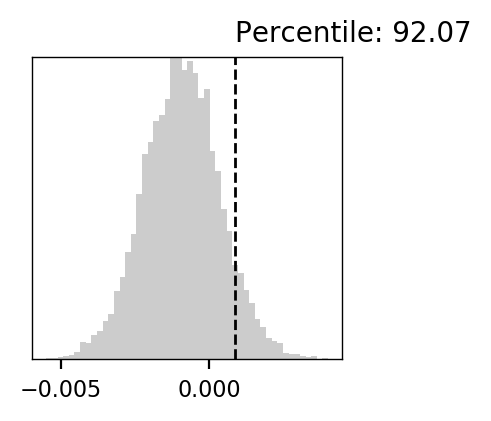

7


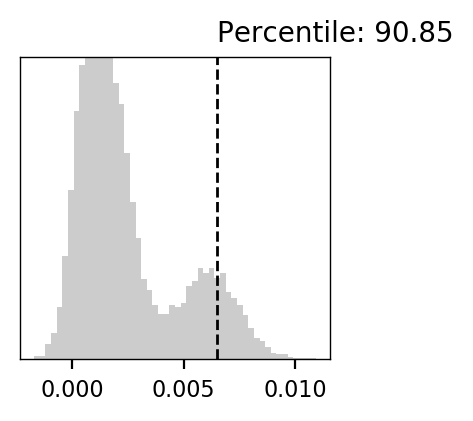

9


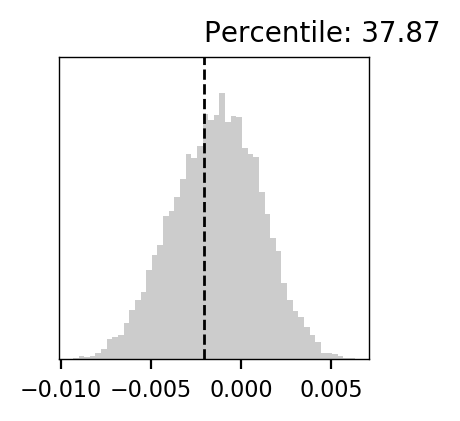

10


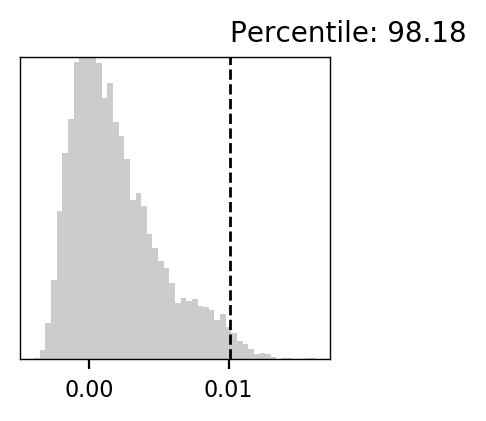

11


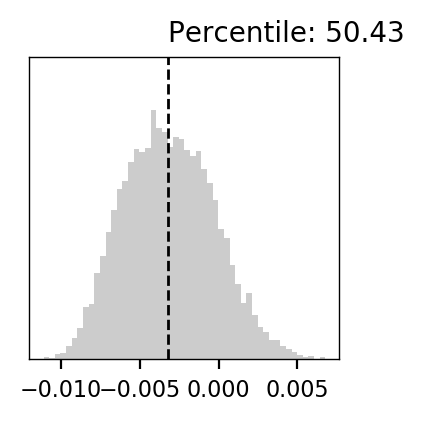

12


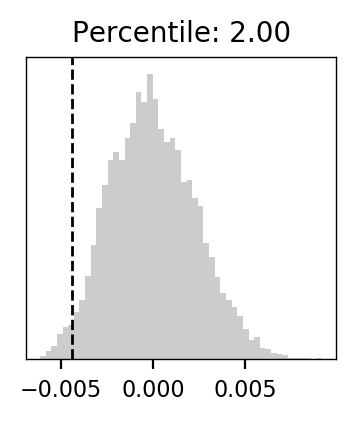

13


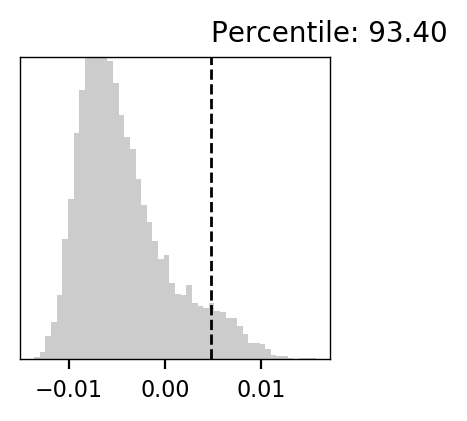

14


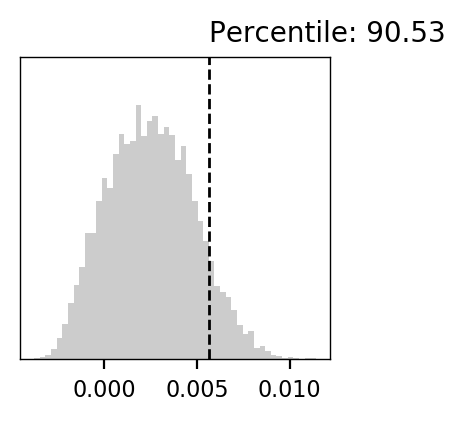

15


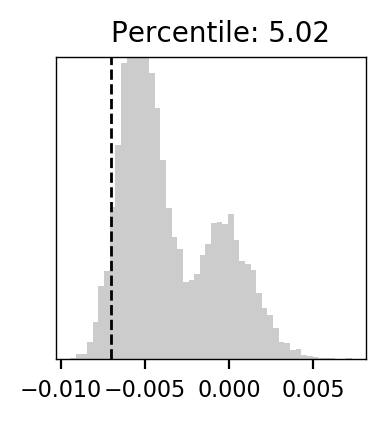

16


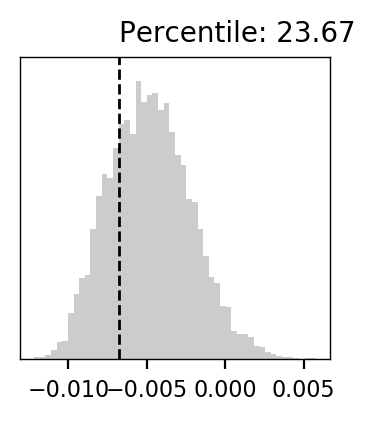

17


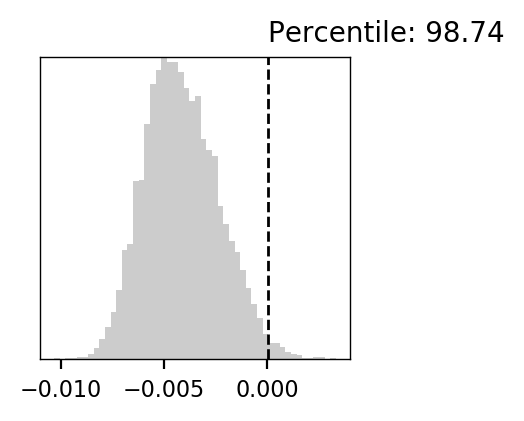

19


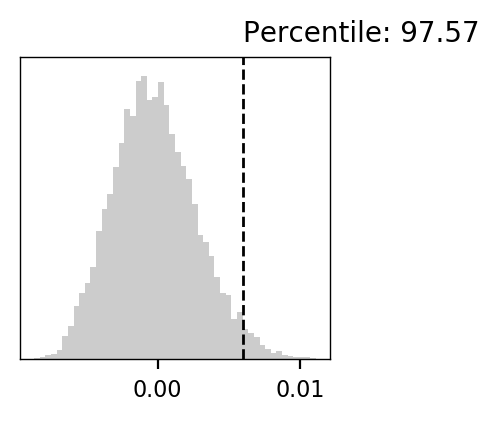

20


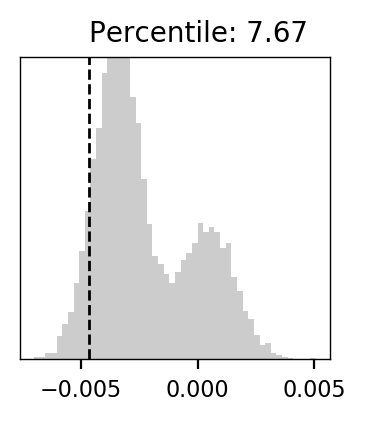

21


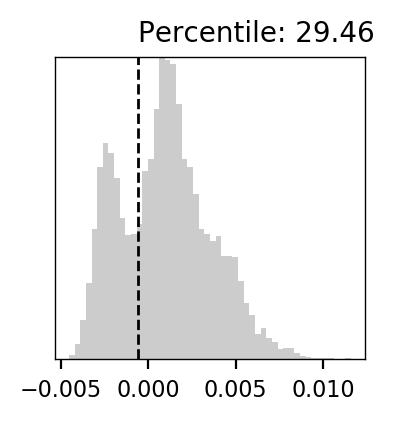

22


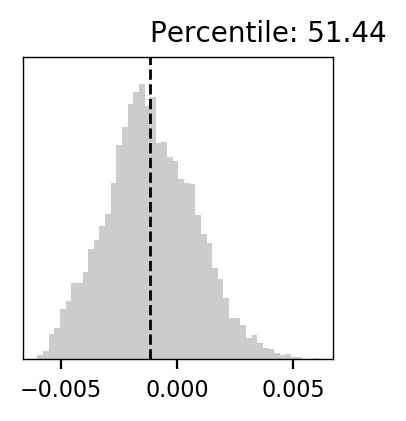

23


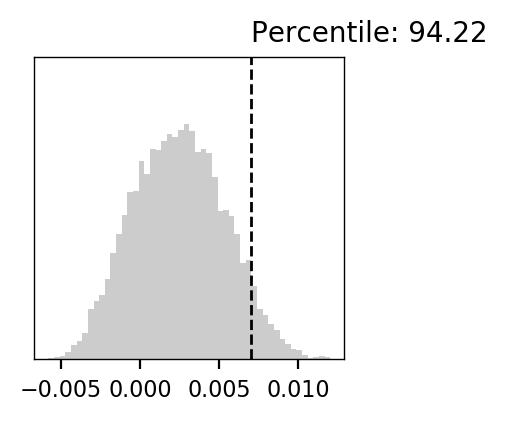

24


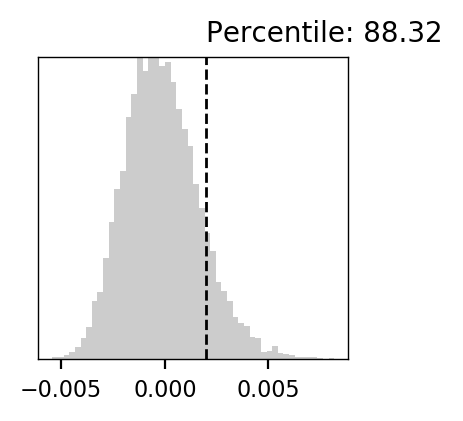

25


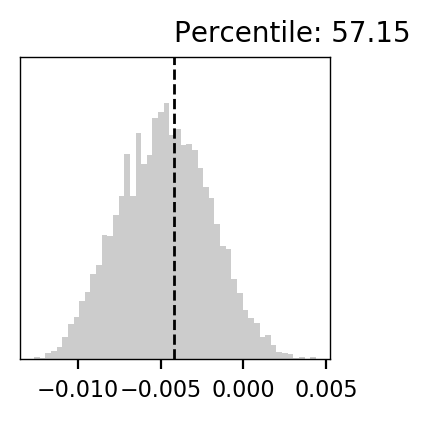

26


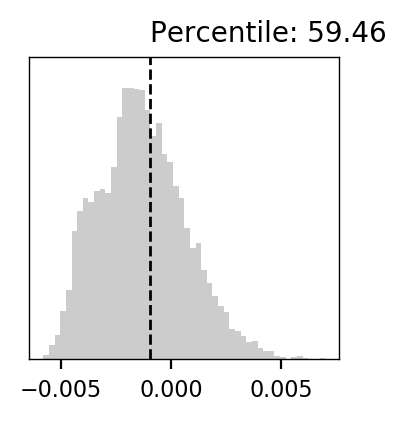

28


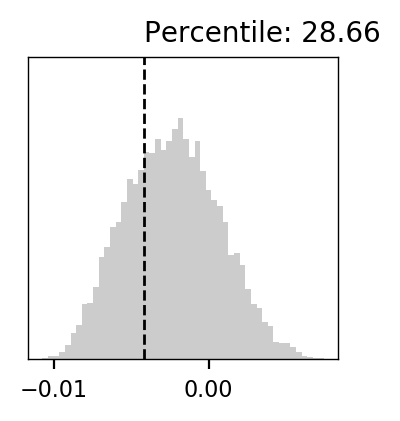

31


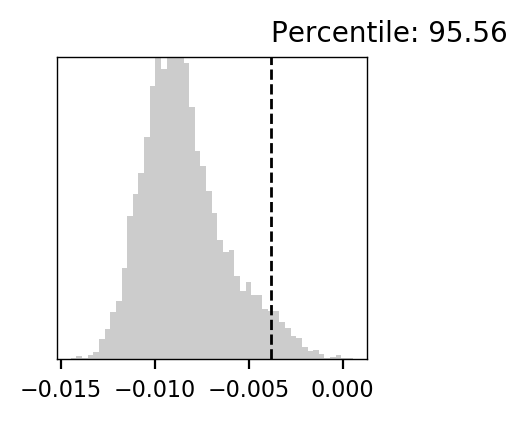

32


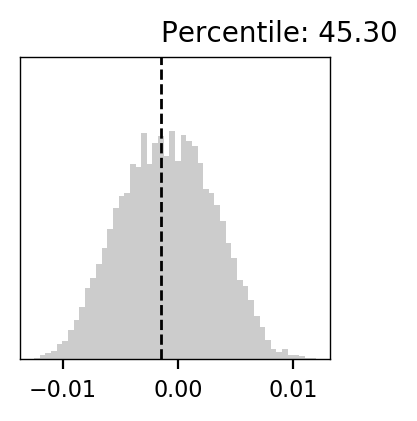

34


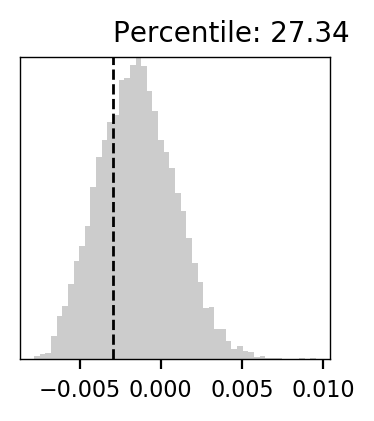

35


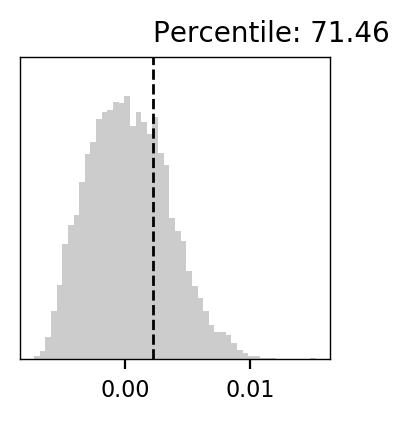

37


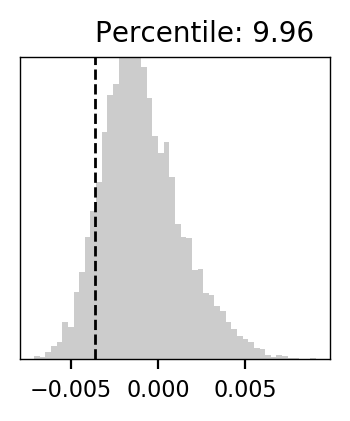

38


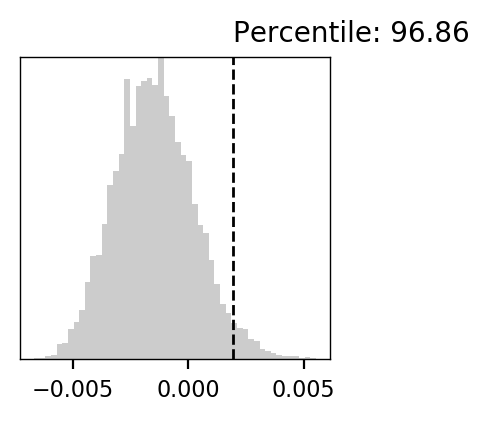

39


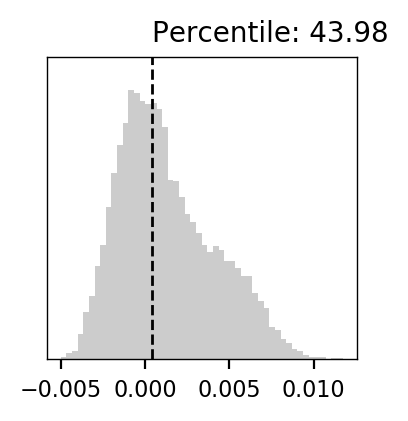

42


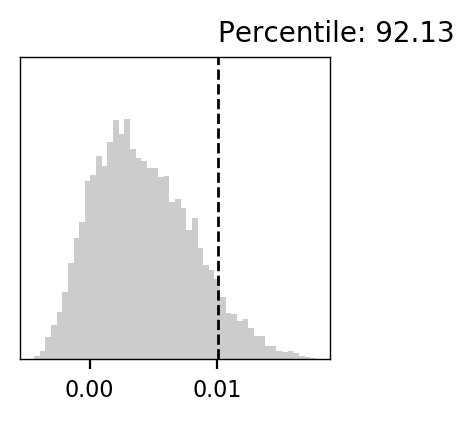

44


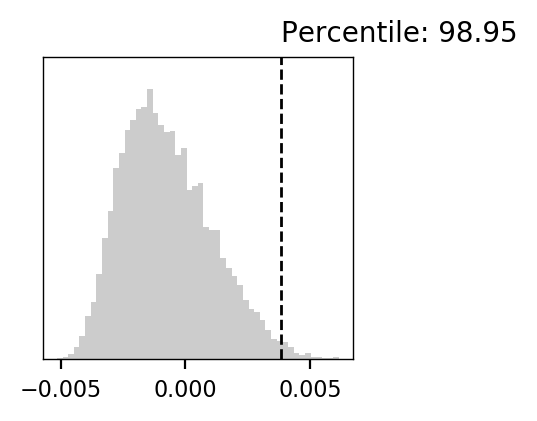

45


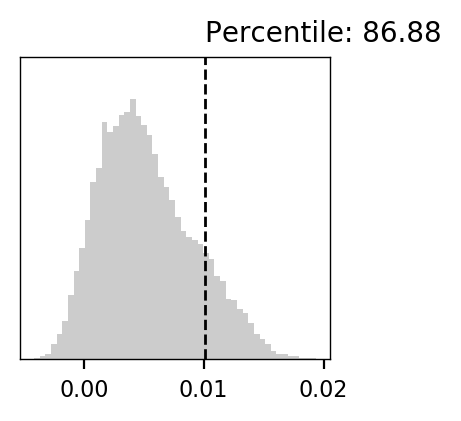

46


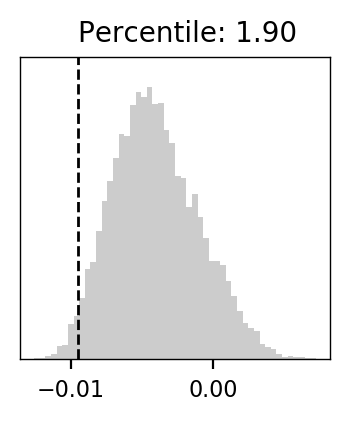

47


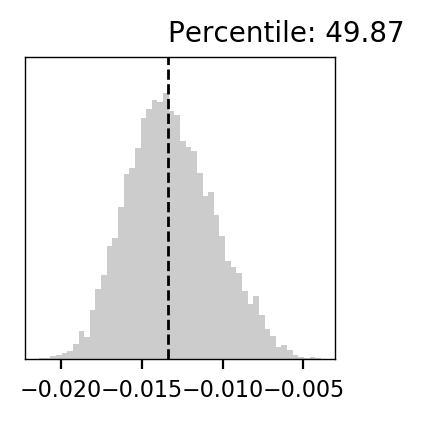

49


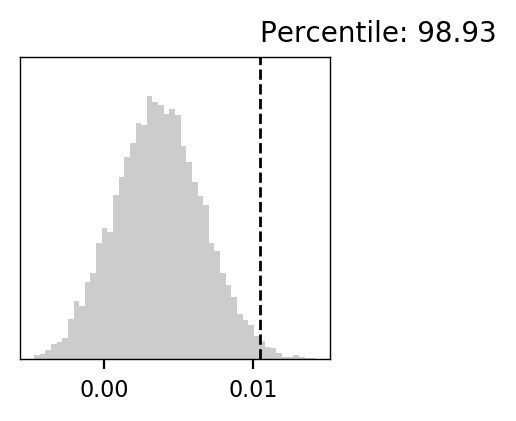

50


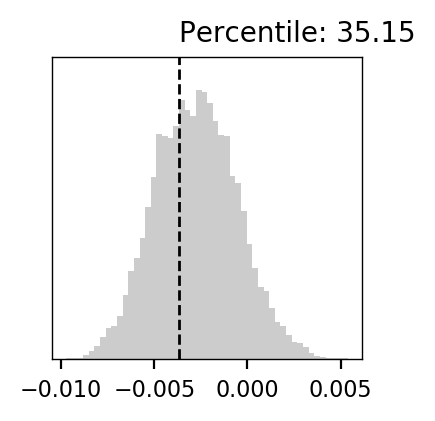

52


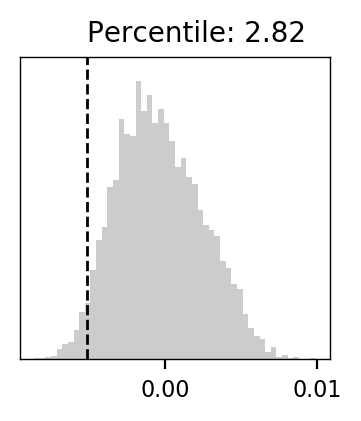

53


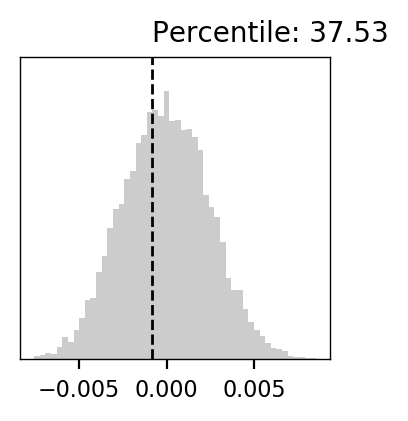

55


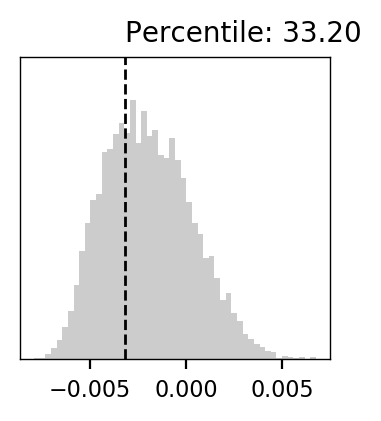

56


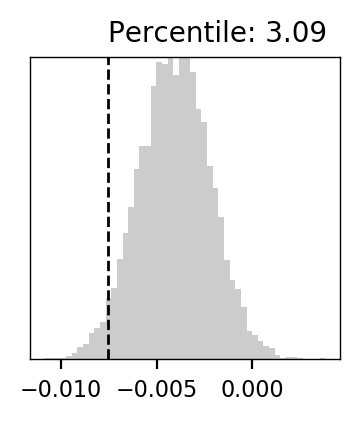

57


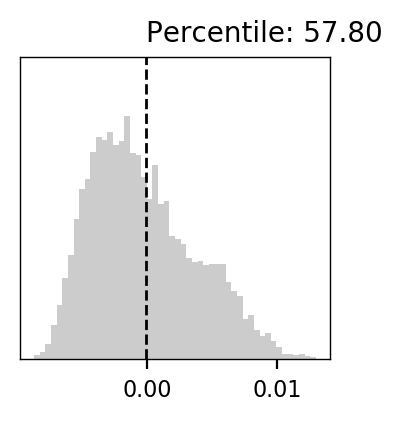

58


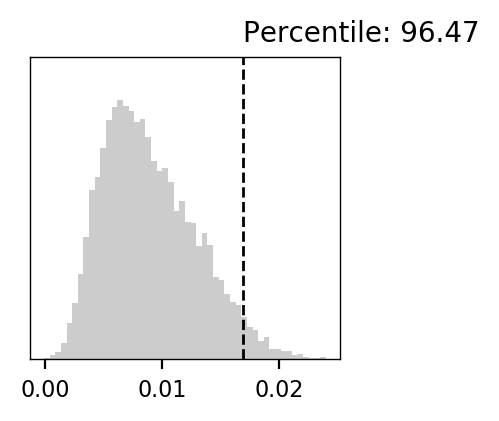

59


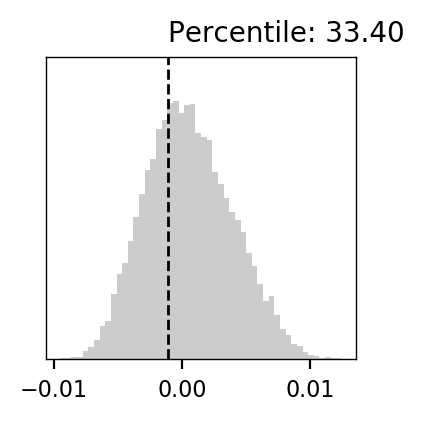

60


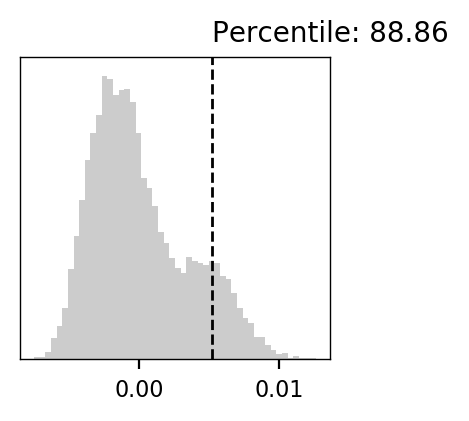

62


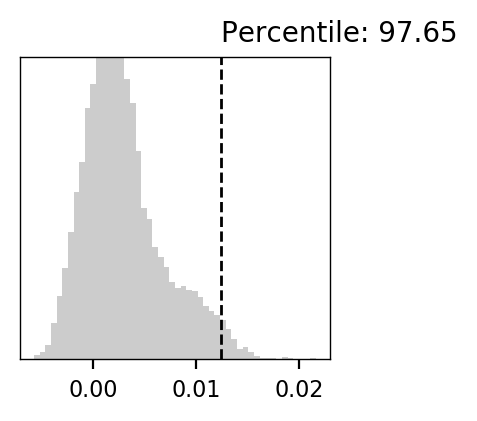

63


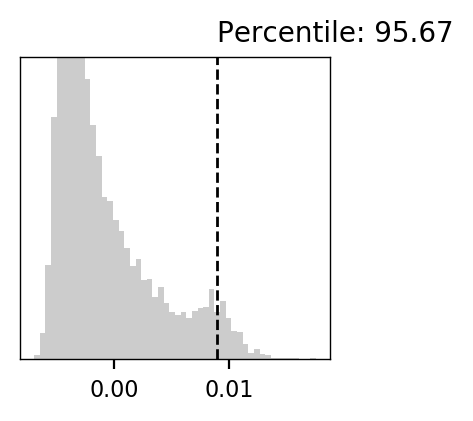

65


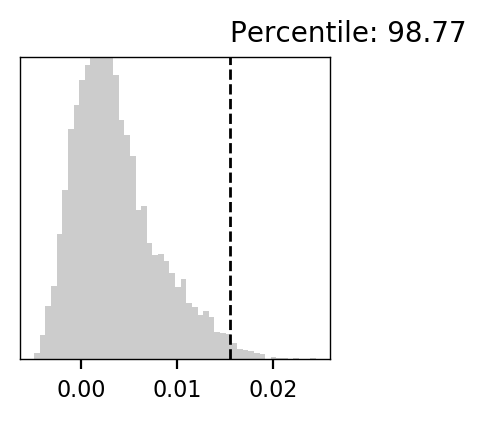

66


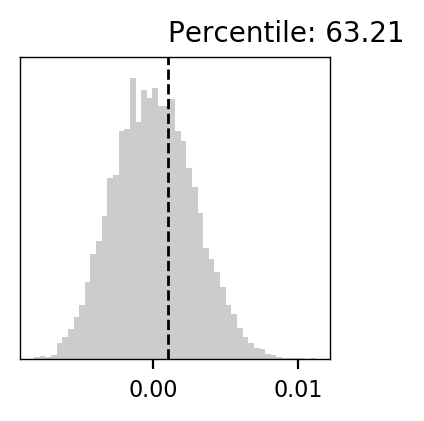

68


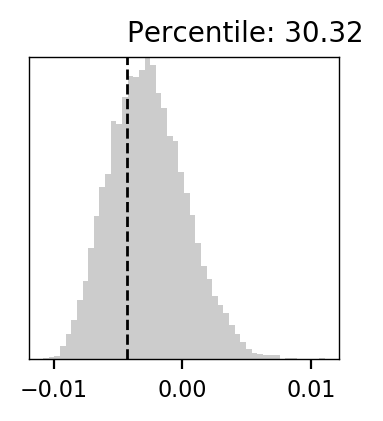

69


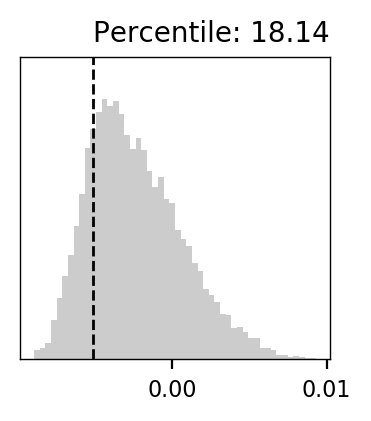

70


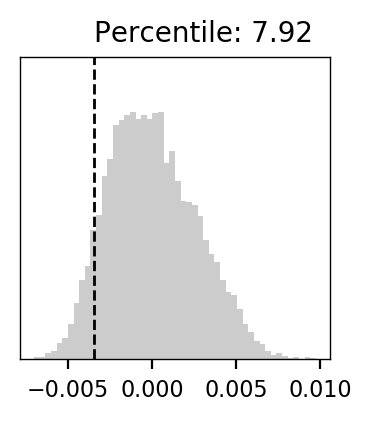

72


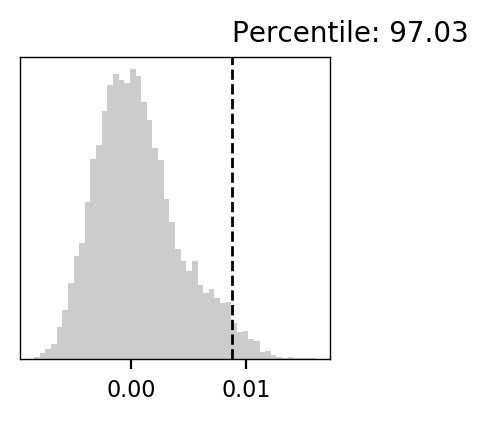

73


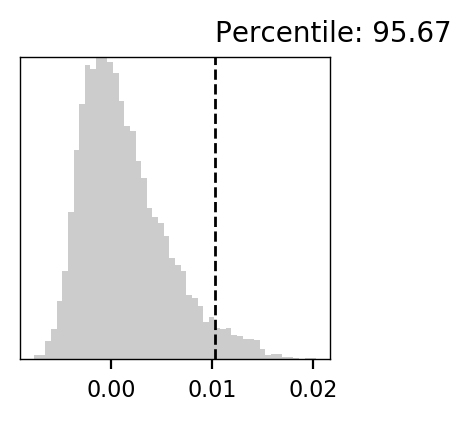

74


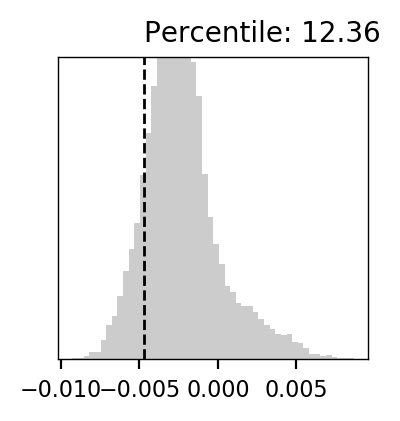

75


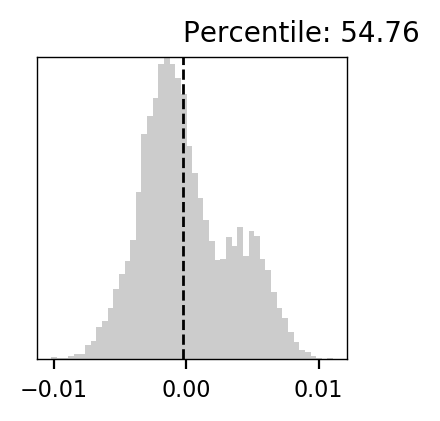

76


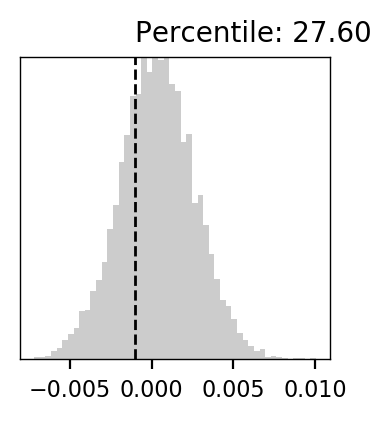

78


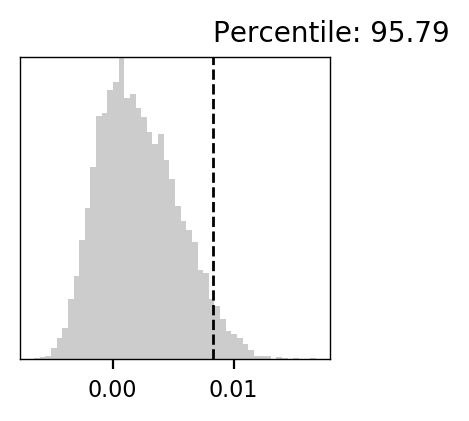

80


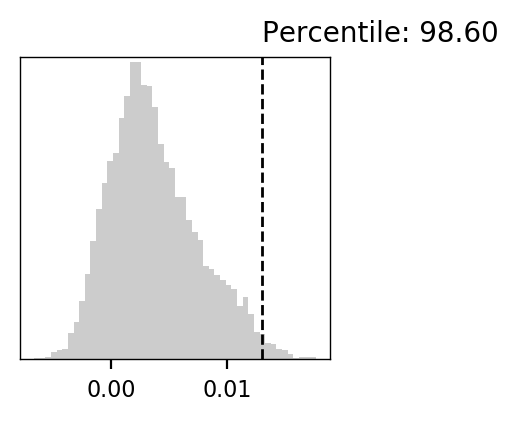

82


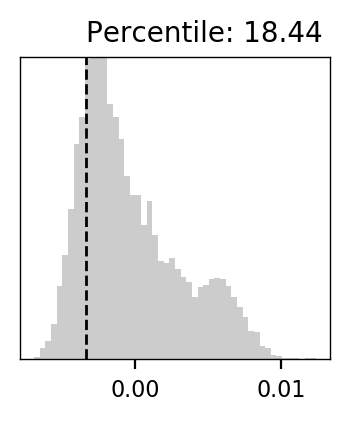

84


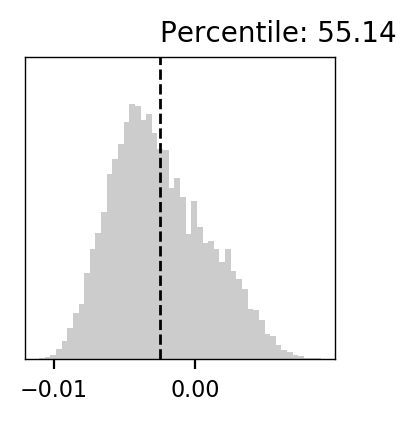

85


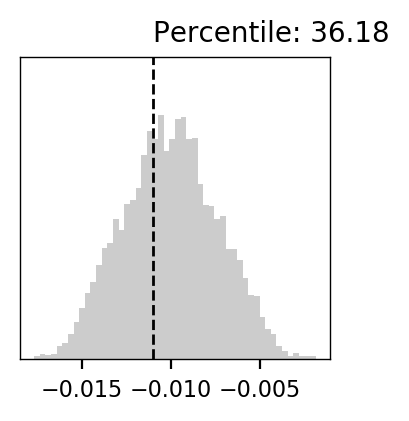

86


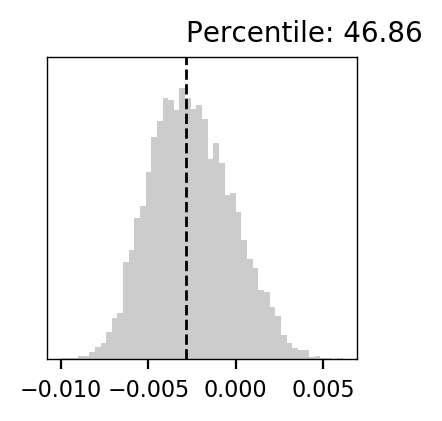

87


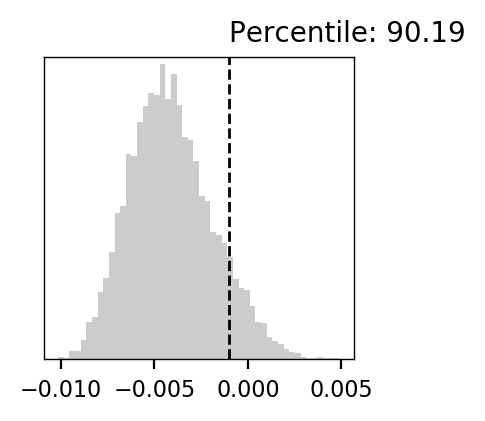

88


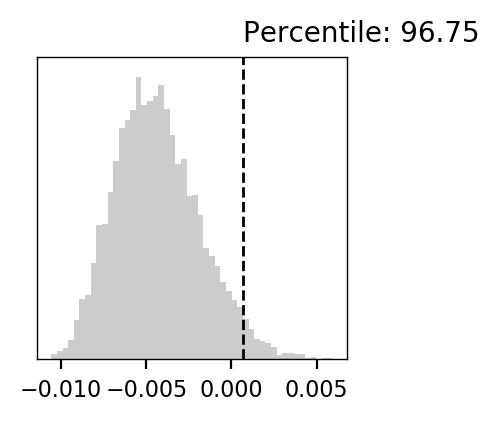

89


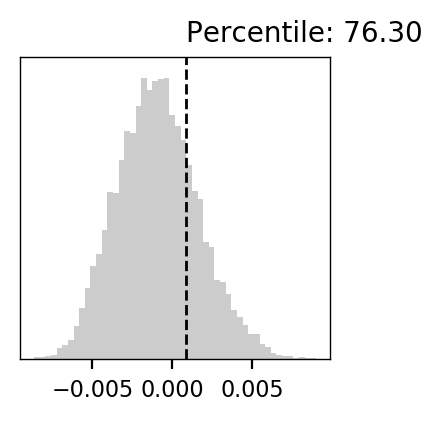

90


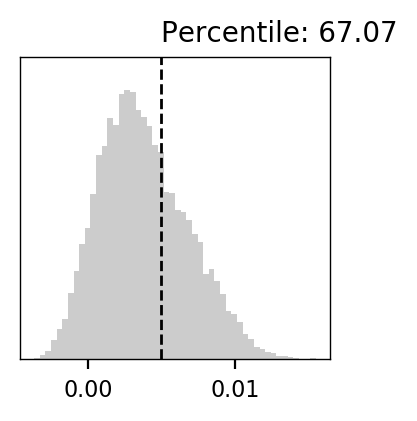

91


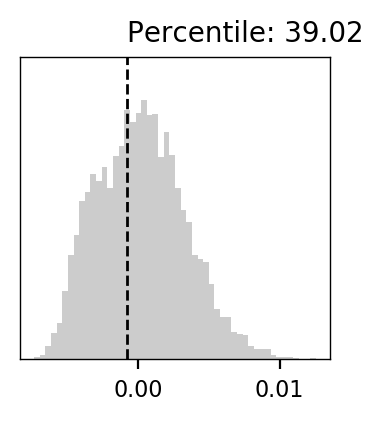

93


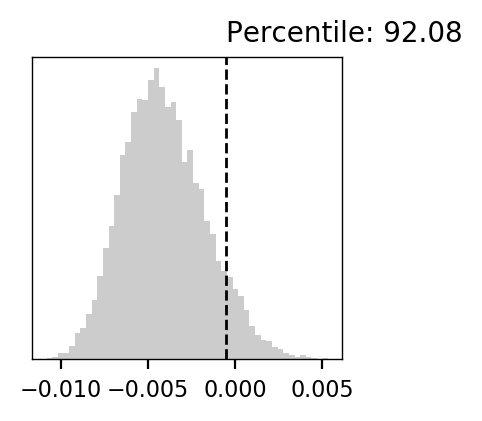

94


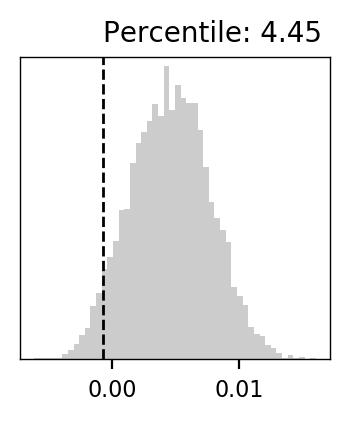

97


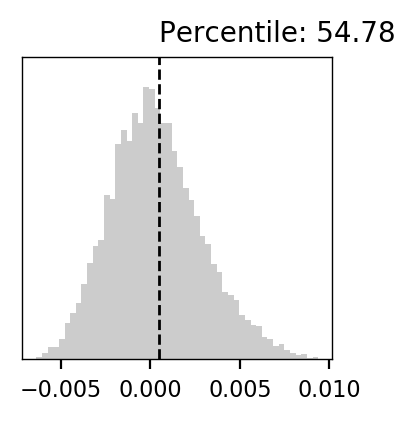

98


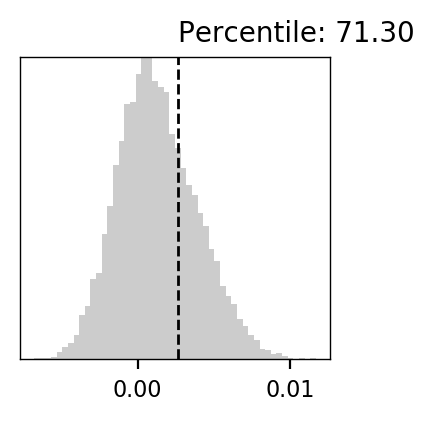

99


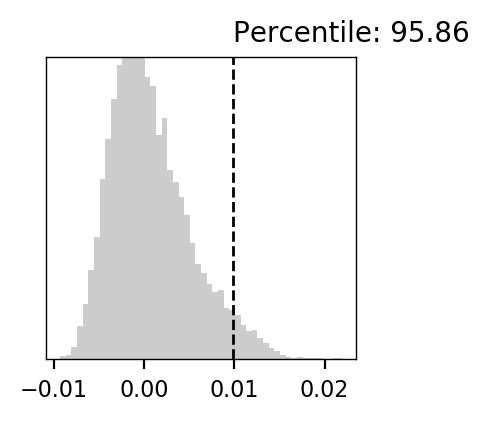

100


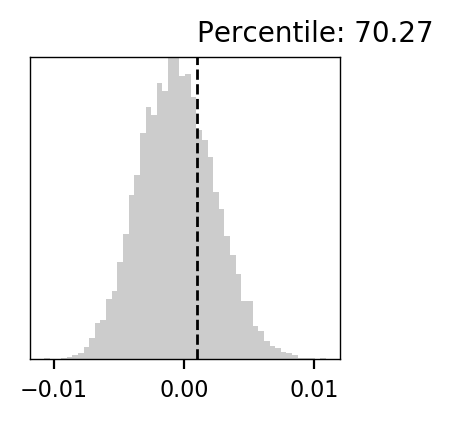

101


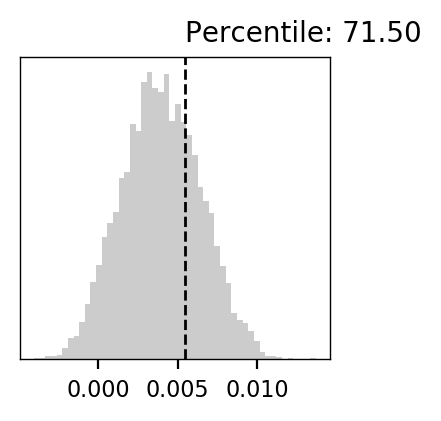

103


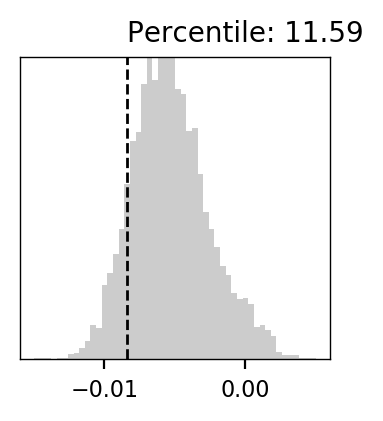

104


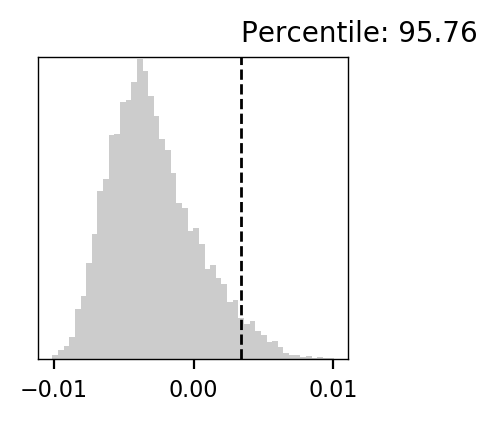

105


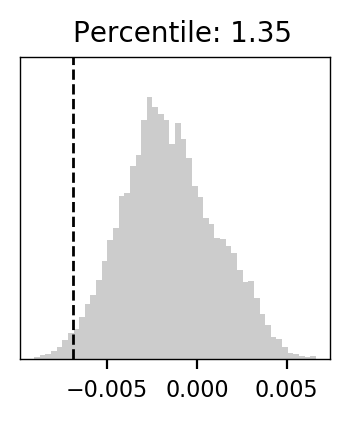

106


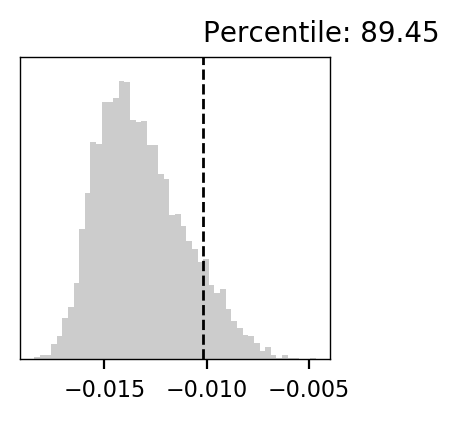

107


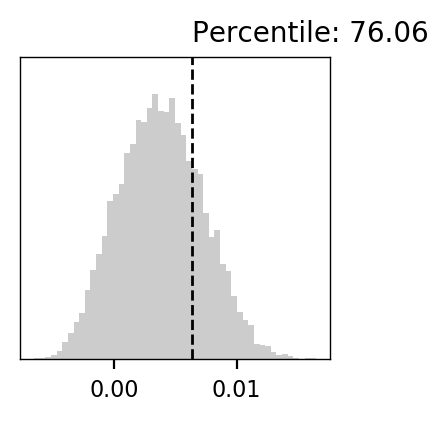

108


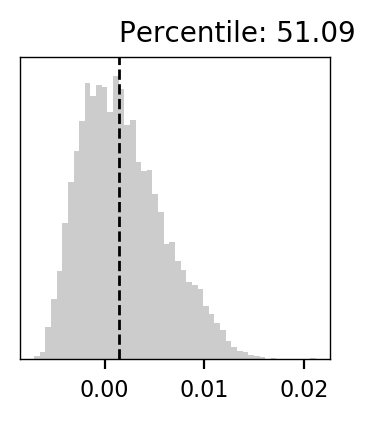

110


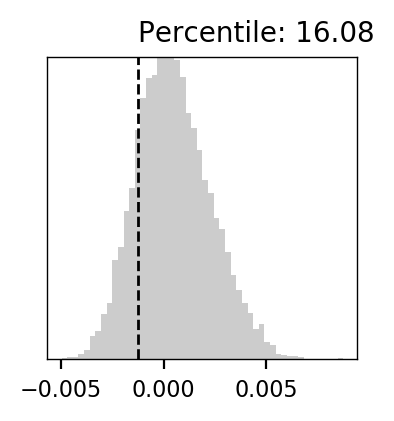

111


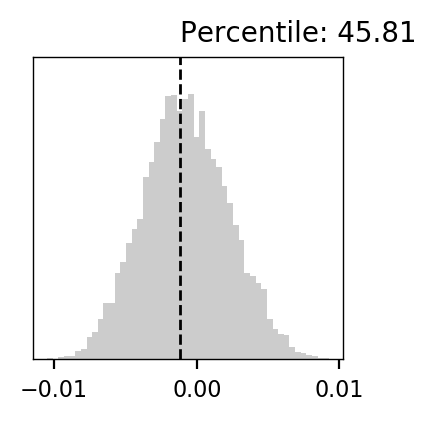

114


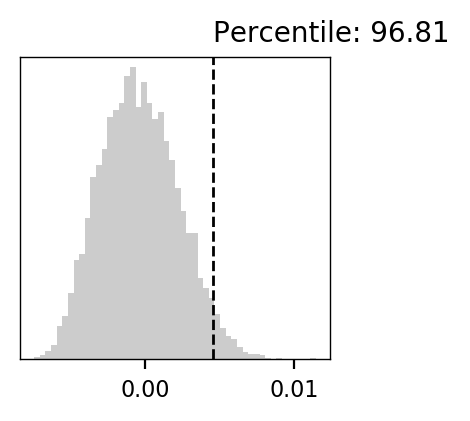

115


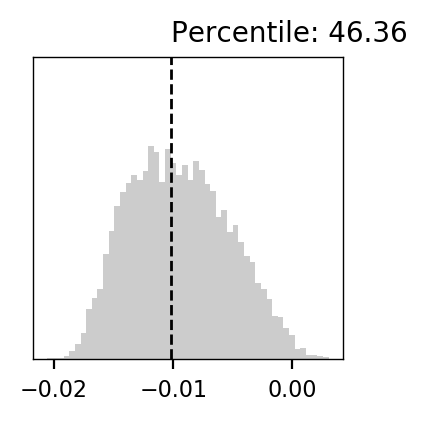

116


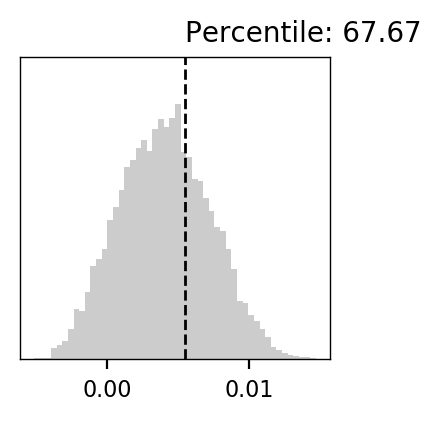

117


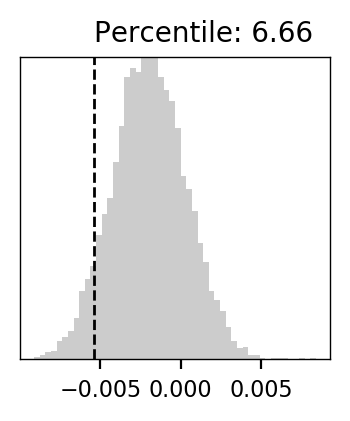

118


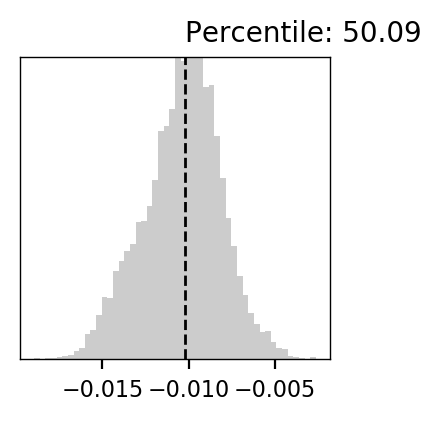

119


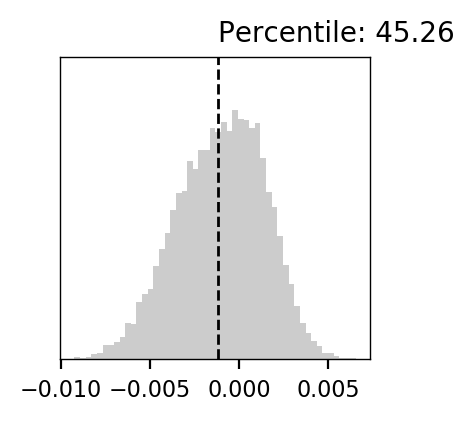

120


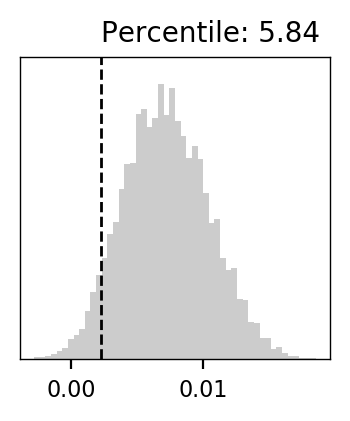

121


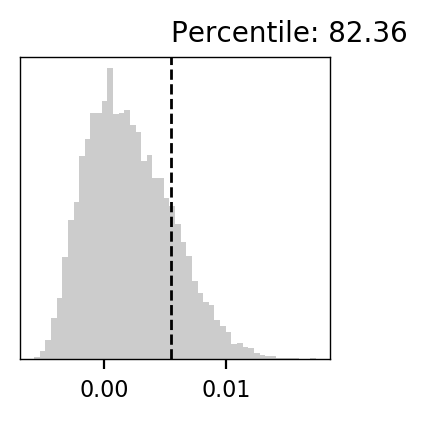

122


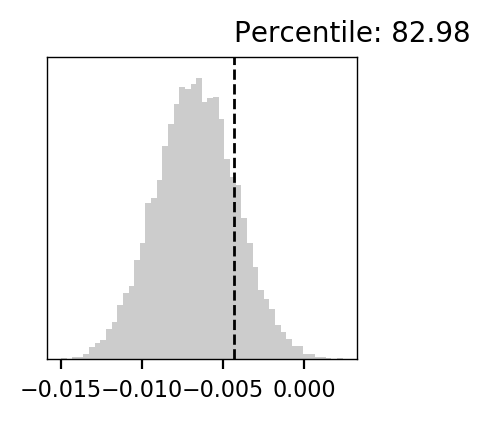

123


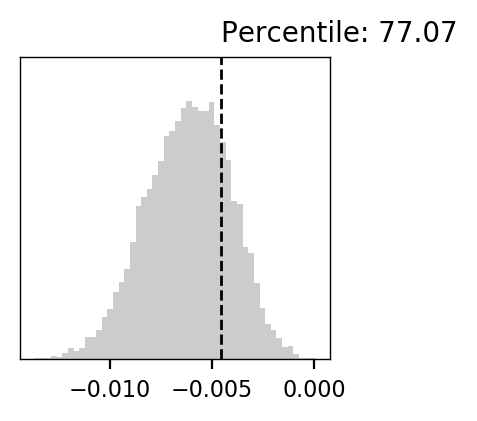

124


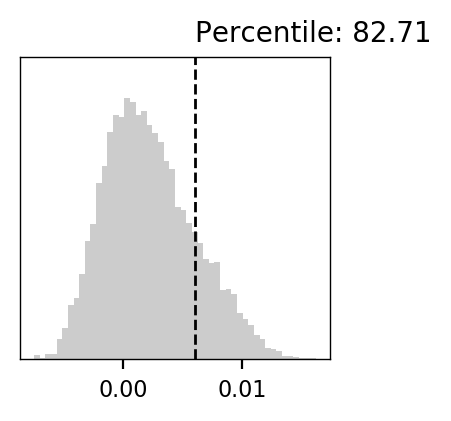

127


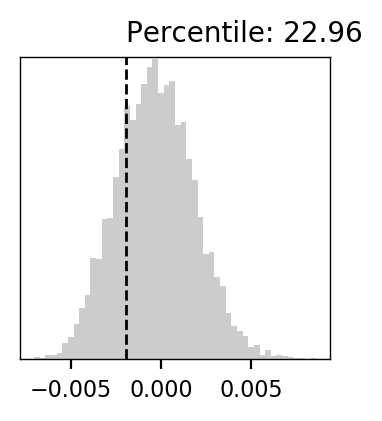

128


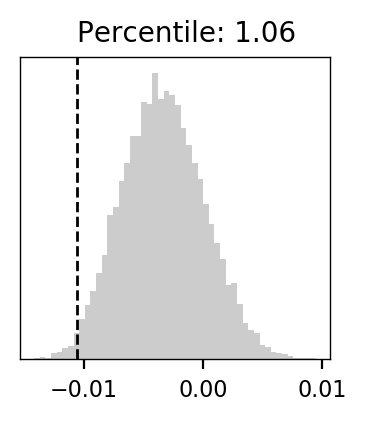

130


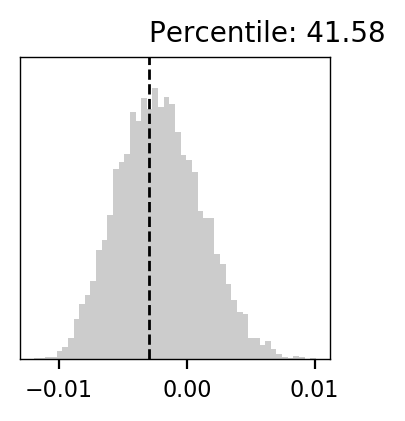

131


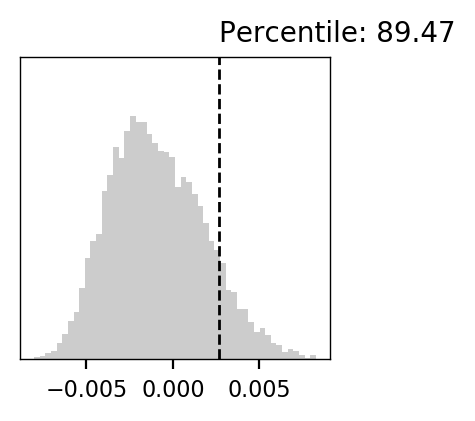

133


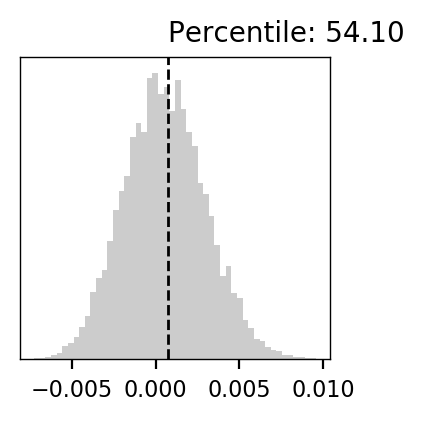

134


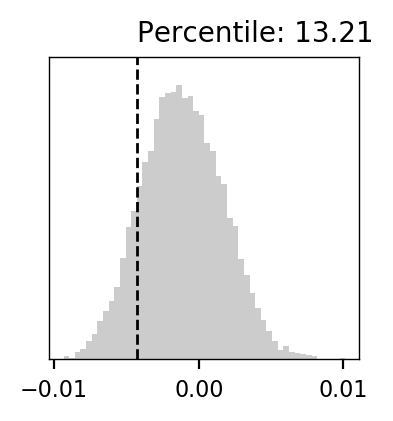

135


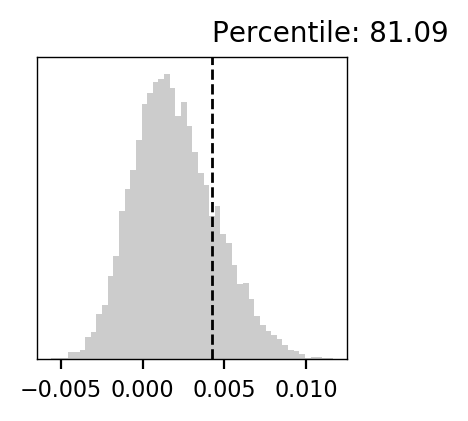

136


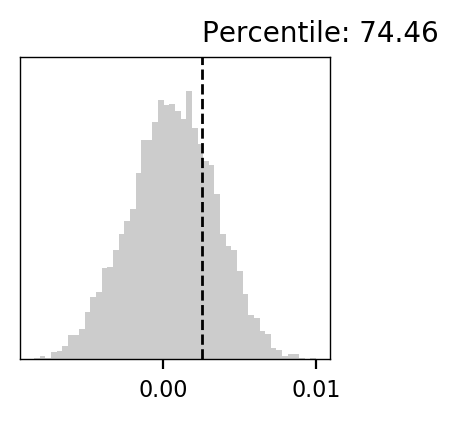

138


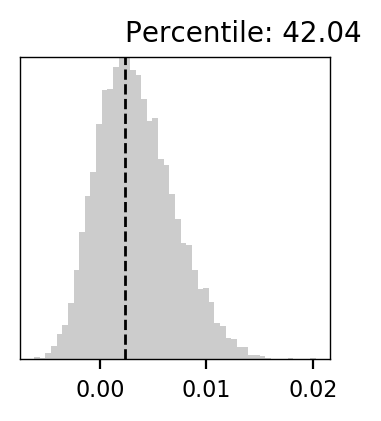

139


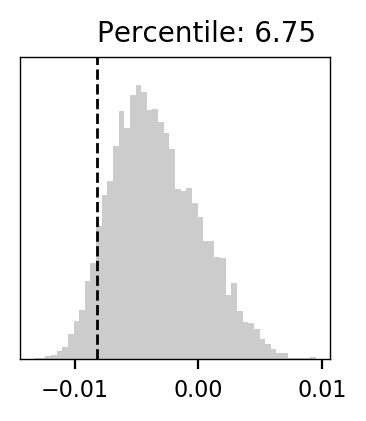

140


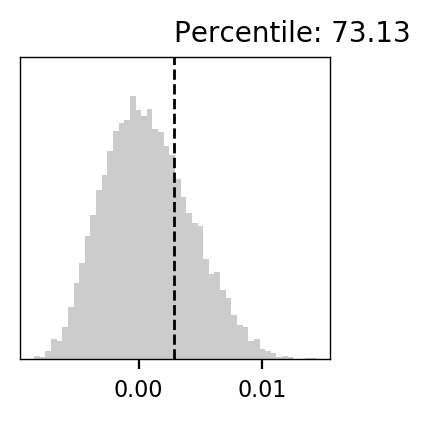

141


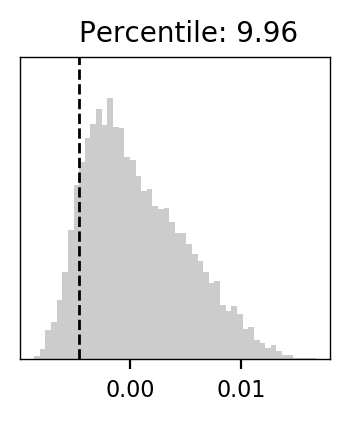

142


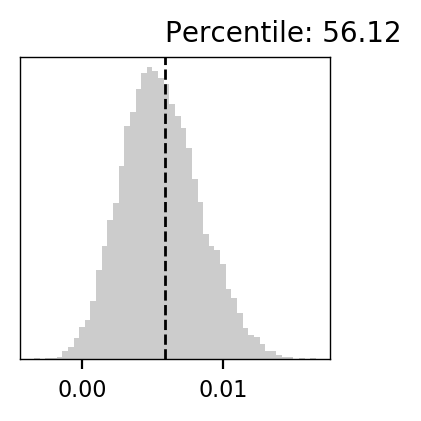

143


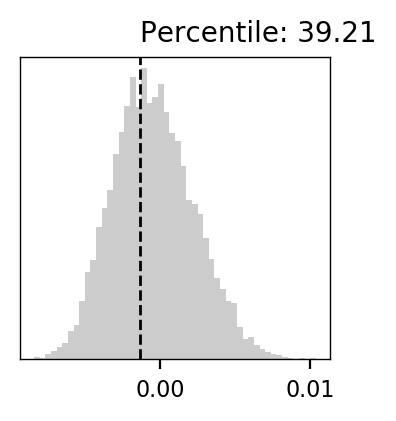

144


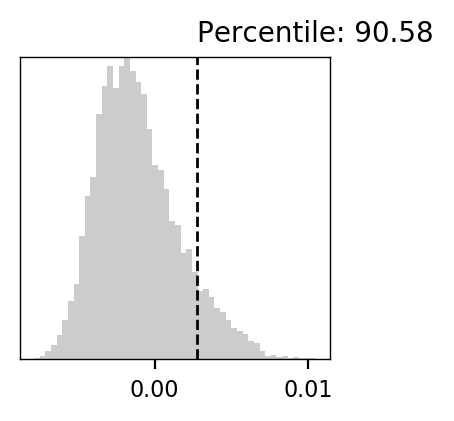

145


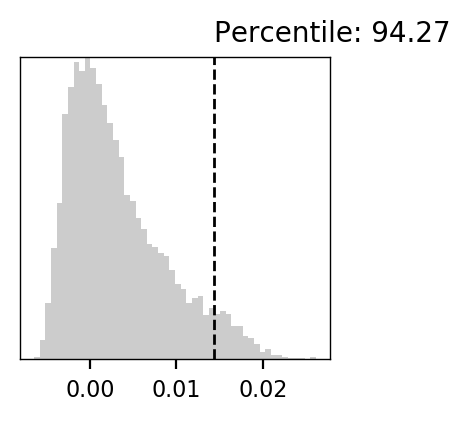

146


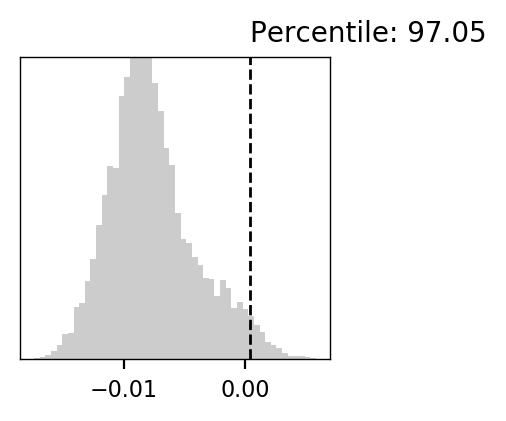

148


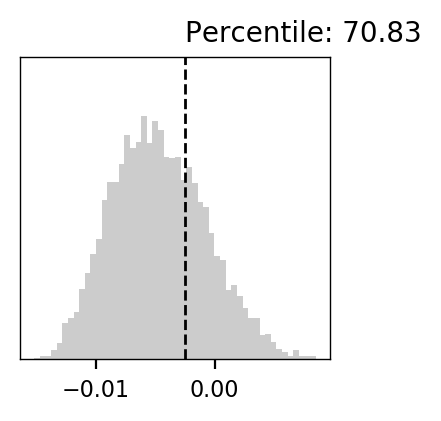

149


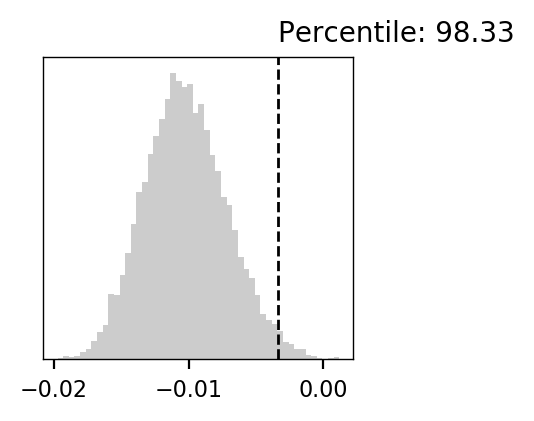

150


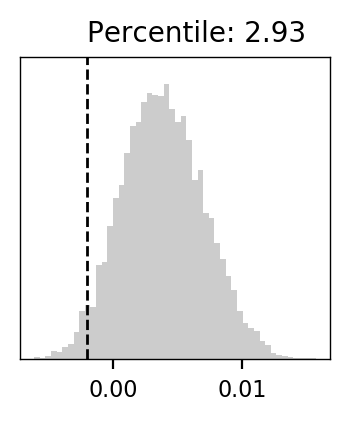

152


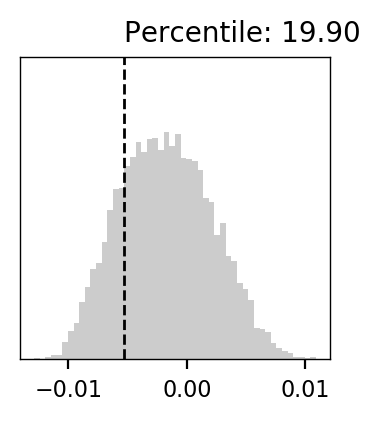

153


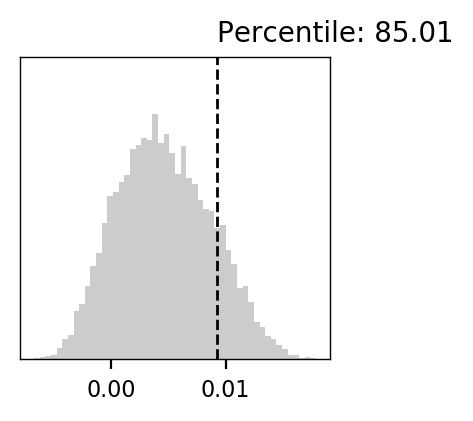

154


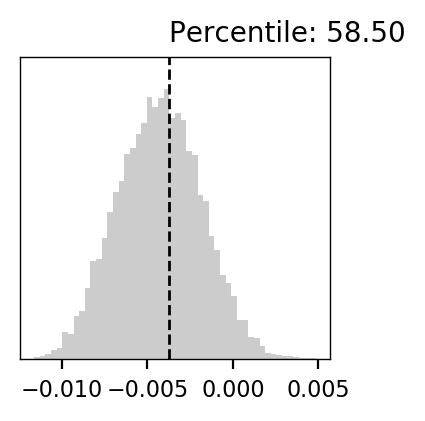

155


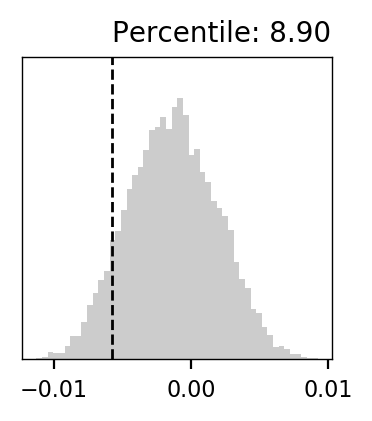

157


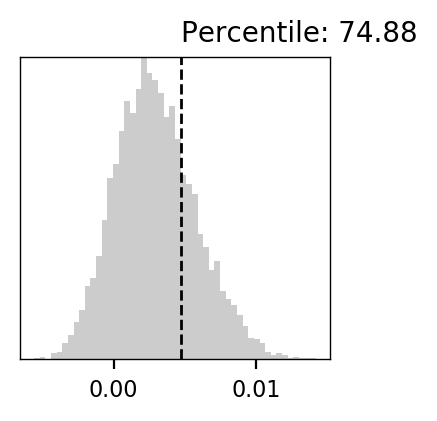

158


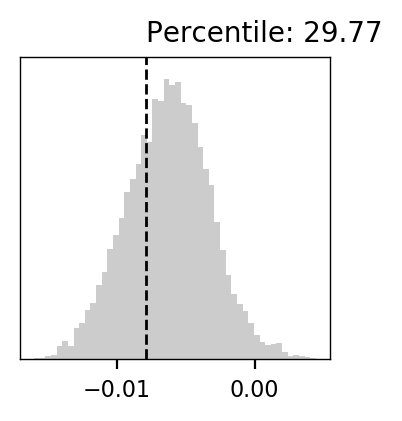

159


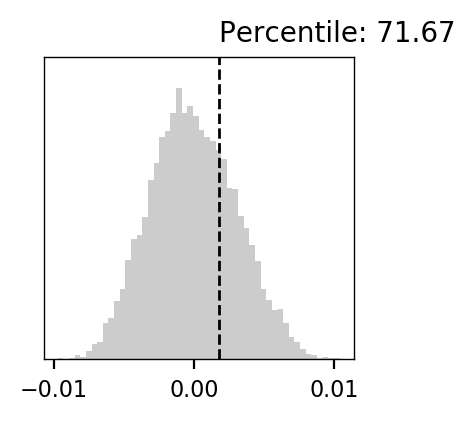

160


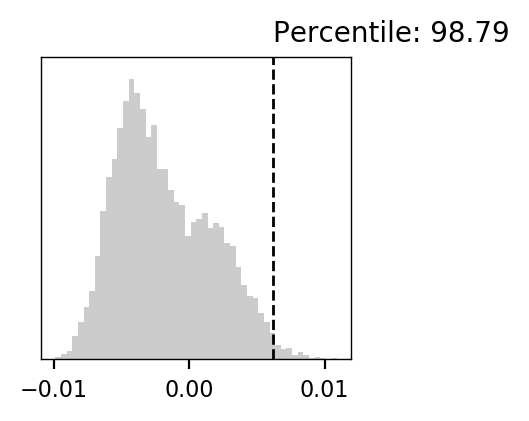

161


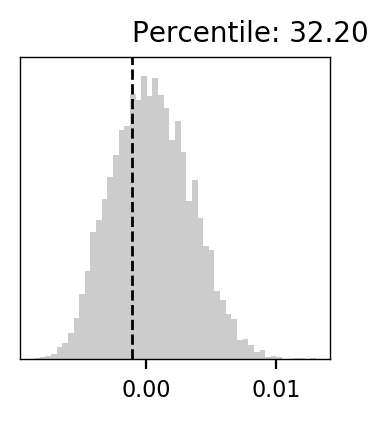

162


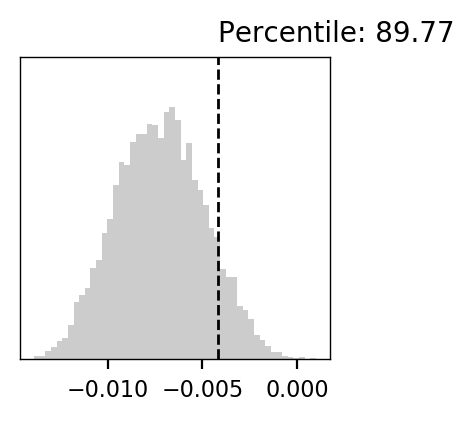

163


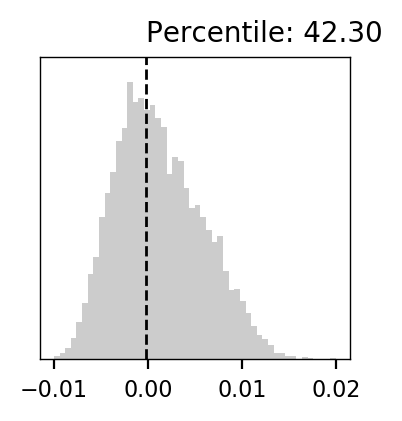

164


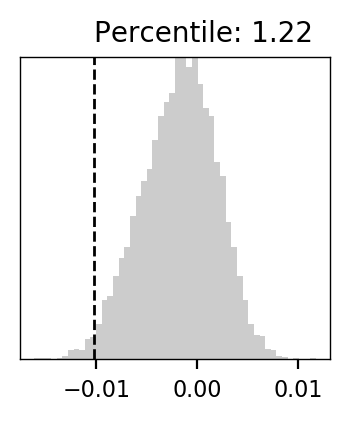

165


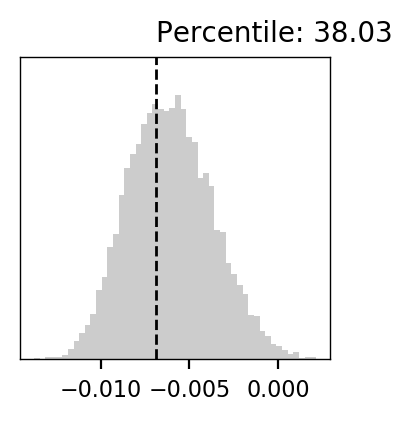

166


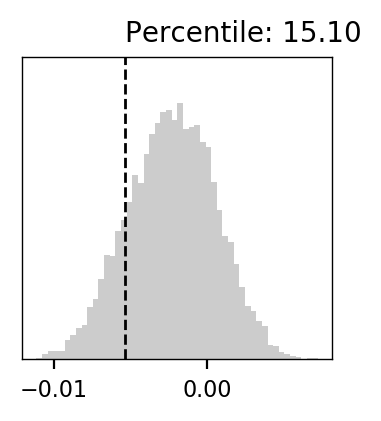

167


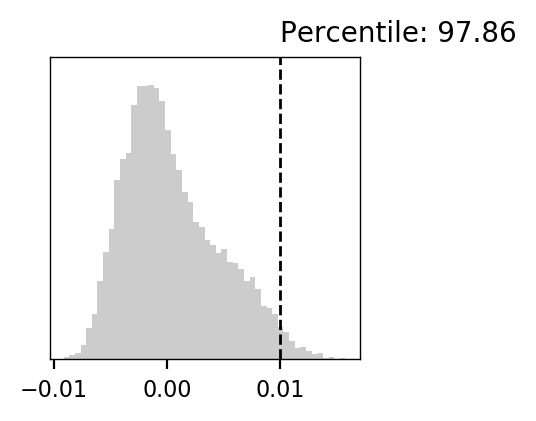

168


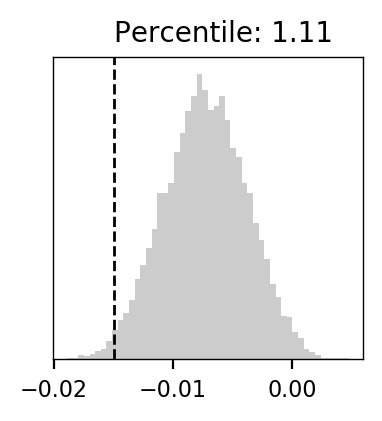

169


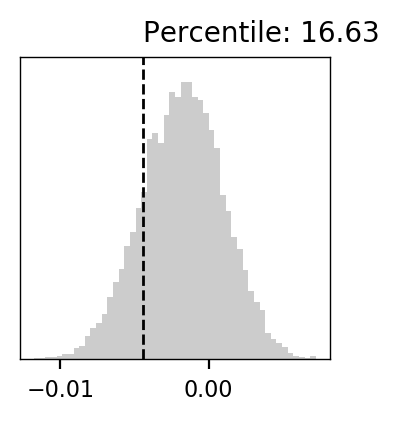

170


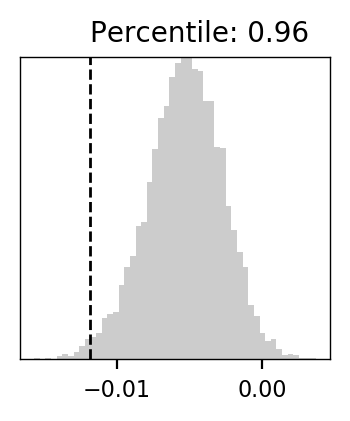

171


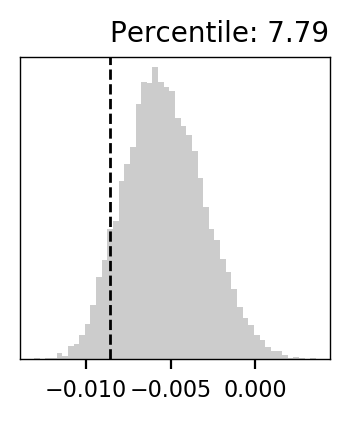

172


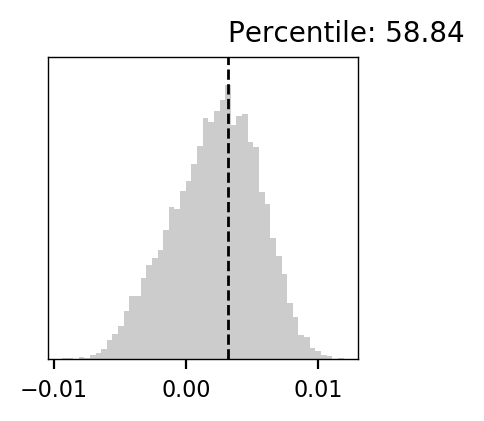

173


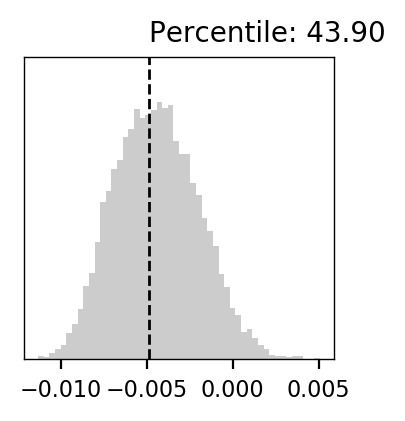

174


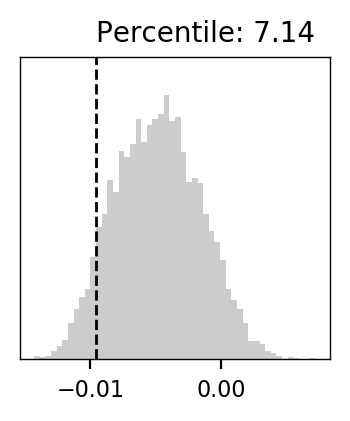

175


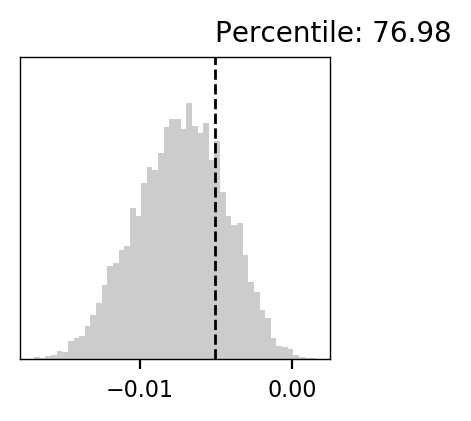

176


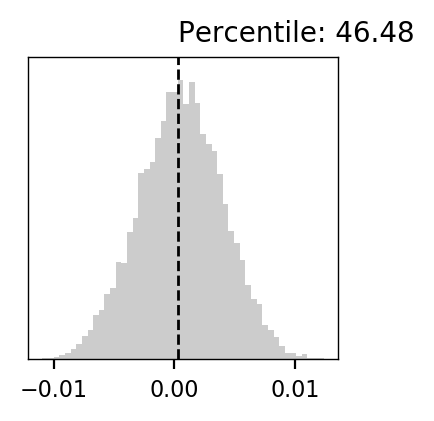

177


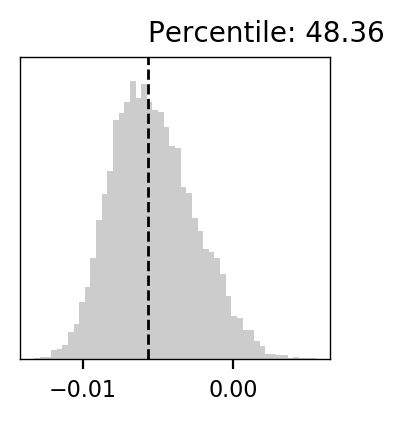

178


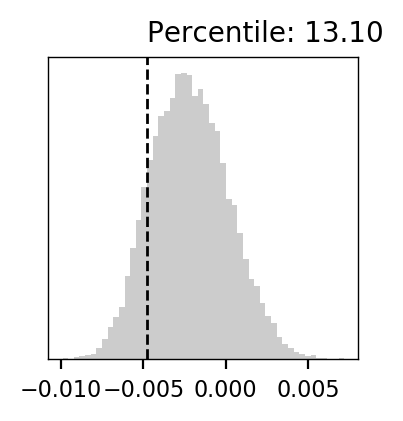

179


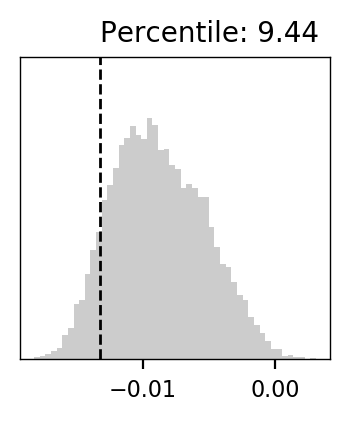

180


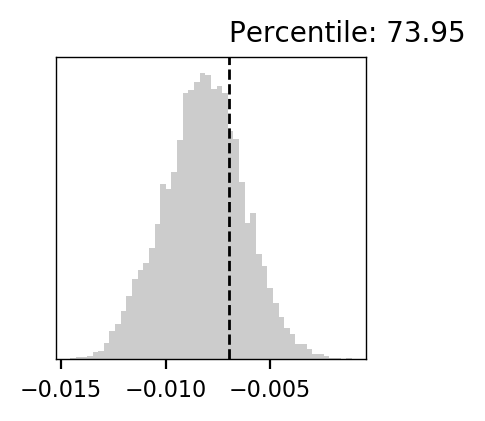

181


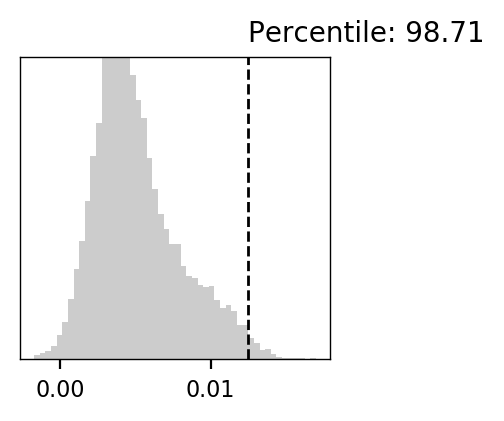

In [485]:
for i in range(len(dist)):
    if 99 > perc[i] > 0.83:
        print(i)


        plt.figure(num=None, figsize=(2, 2), dpi=200, facecolor='w', edgecolor='k')
        # plt.hist(dist[27], bins = 50, color = 'dodgerblue')

        sns.distplot(dist[i], bins = 50,  color = 'gray', kde=False)
        # sns.kdeplot(dist[27], shade=True, color = 'dodgerblue')

        plt.axvline(similarity[i], color='k', linestyle='dashed', linewidth=1)
        plt.ylim(0,600)
        plt.tick_params(bottom=True, left=False, right=False, labelleft=False, labelbottom=True)

        _, max_ = plt.ylim()
        plt.text(similarity[i],
                 max_ + max_/20, 
                 'Percentile: {:.2f}'.format(perc[i]))


        
#         plt.xlabel("Similarity")
#         plt.ylabel("Number of occurence")
        plt.show()

In [17]:
#get the names back
ON_neurons = []
OFF_neurons = []
for neuron in range(len(cells_dictionary)):
    for i in on:
        if neuron == i:
            ON_neurons.append(cells_dictionary[neuron])
    for i in off:
         if neuron == i:
            OFF_neurons.append(cells_dictionary[neuron])
            
print(ON_neurons, OFF_neurons)

[' C003', ' C008', ' C018', ' C027', ' C029', ' C030', ' C041', ' C043', ' C051', ' C054', ' C061', ' C064', ' C077', ' C079', ' C083', ' C092', ' C096', ' C102', ' C109'] [' C036', ' C040', ' C048', ' C067', ' C081', ' C095', ' C112', ' C113']
